<h1 style="text-align:center;font-size:50px;" > Severstal: Steel Defect Detection </h1>

![alt text](https://drive.google.com/uc?id=14XiYMQgRKb6DwHRR9o4F29NBmFETyMC1)

# 1.0 Business Problem

## 1.1 Description

Severstal is leading the charge in efficient steel mining and production. With over 50K employees, 5K clients, and 25K products, this company has produced 11.8 Million tonnes of steel, 4.7 Million tonnes of coal and 11 Million tonnes of iron core pellets in 2019 which justifies its dominance in the steel industry.

We know that steel is one of the most important and most widely used building materials of modern times due to its impressive properties like durability, thermal conductivity, resistance to natural and man-made wear and most importantly it is resistant to corrosion which makes the material ubiquitous around the world. In order to make steel production more efficient without compromising the quality, Severstal wants to leverage the advances of Artificial Intelligence like computer vision to identify defects in delicate flat steel sheets. These sheets are produced from a sequence of manufacturing processes that involves heating, rolling, drying and cutting

Off lately, Severstal is using images generated form high frequency cameras to power a defect detection algorithm and  Severstal is expecting the AI engineers to improve the algorithm to detect defects with high precision.

Credits: Kaggle 

__ Problem Statement __
- Detect and localize the surface defects on a steel sheet provided the image of steel sheets.
- Classify the detected surface defects  into one or multiple classes among class values [1, 2, 3, 4]

## 1.2 Sources/Useful Links

- Source : https://www.kaggle.com/c/severstal-steel-defect-detection/overview
<br><br>____ Useful Links ____
- References : 
- https://forums.fast.ai/t/understanding-the-dice-coefficient/5838
- https://www.kaggle.com/wh1tezzz/correct-dice-metrics-for-this-competition
- https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/
- https://www.kaggle.com/go1dfish/clear-mask-visualization-and-simple-eda
- https://www.kaggle.com/cdeotte/keras-unet-with-eda
- https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly

## 1.3 Real world/Business Objectives and Constraints

1. No strict latency concerns but defect identification and localization should not take a long time. In an ideal situation it is desirable to match with the frequency of cameras.
2. Interpretability can be obtained in the form of probability values for each of 4 class labels.

# 2.0 Machine Learning Probelm

## 2.1 Data

### 2.1.1 Data Overview

The data folder (size 2GB in total) provided by Severstal contains the following:

- train_images/ - folder of training images
- test_images/ - folder of test images (you are segmenting and classifying these images)
- train.csv - training annotations which provide segments for defects (ClassId = [1, 2, 3, 4])
- sample_submission.csv - a sample submission file in the correct format, with each ImageId repeated 4 times, one for each     of the 4 defect classes

### 2.1.2 Example Data point

**Sample train image**

![sample](https://drive.google.com/uc?id=1bCZOwQ2K_Hy9-6D61ua2xDJypFa4YM7w)

**train_csv data point**

![sample](https://drive.google.com/uc?id=1Aa8lxmO4ULuMKWrtw9hzXK5zG8TQgdro)

## 2.2 Mapping the real world problem to an ML problem 

### 2.2.1 Type of Machine Leaning Problem 

- This is an image segmentation and a classification problem to predict, localize the defects and then classify the detected defects

### 2.2.2 Performance Metric

- Dice coefficient. 
- https://forums.fast.ai/t/understanding-the-dice-coefficient/5838
- https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient

## 2.3 Train, CV and Test construction 

- Training images will be split randomly into train & CV in the ratio 85:15.
- Testing images will be used for predictions.

# 3.0 Exploratory Data Analysis

### Importing all the modules

In [0]:
import warnings
warnings.filterwarnings("ignore")
from datetime import datetime
import pandas as pd
import numpy as np
from numpy import asarray
import matplotlib.pyplot as plt
%matplotlib notebook
%matplotlib inline
import seaborn as sns
from sklearn import metrics
import pickle
from tqdm import tqdm
import math
import random
import os
import cv2
from collections import Counter
from os import listdir
from matplotlib import image
from matplotlib import pyplot
from PIL import Image
from collections import defaultdict
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras import backend as K
from keras.losses import binary_crossentropy
from keras.layers import UpSampling2D, Conv2D, Activation, LeakyReLU, BatchNormalization,Input,Conv2DTranspose,Dropout
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras import Model
from keras.preprocessing.image import ImageDataGenerator,array_to_img, img_to_array, load_img
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, LearningRateScheduler,Callback
from keras.optimizers import Adam
from tqdm import tqdm_notebook
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate,add

Using TensorFlow backend.


## 3.1 Loading train csv file

In [0]:
#loading the train csv file containing pixels indicating defects  
train_df= pd.read_csv("/content/train.csv")
train_df.head()

ImageId  ClassId                                      EncodedPixels
0  0002cc93b.jpg        1  29102 12 29346 24 29602 24 29858 24 30114 24 3...
1  0007a71bf.jpg        3  18661 28 18863 82 19091 110 19347 110 19603 11...
2  000a4bcdd.jpg        1  37607 3 37858 8 38108 14 38359 20 38610 25 388...
3  000f6bf48.jpg        4  131973 1 132228 4 132483 6 132738 8 132993 11 ...
4  0014fce06.jpg        3  229501 11 229741 33 229981 55 230221 77 230468...

EncodedPixels columns indicate run-length encoding on the pixel values which are pairs of values that contain a start position and a run length. E.g. '1 3' implies starting at pixel 1 and running a total of 3 pixels (1,2,3).

The competition format requires a space delimited list of pairs. For example, '1 3 10 5' implies pixels 1,2,3,10,11,12,13,14 are to be included in the mask. The metric checks that the pairs are sorted, positive, and the decoded pixel values are not duplicated. The pixels are numbered from top to bottom, then left to right: 1 is pixel (1,1), 2 is pixel (2,1), etc.

In [0]:
print(train_df.shape)

(7095, 3)


- There are 7095 datapoints or steel sheet images containing defects

## 3.2 Checking for NaN

In [0]:
# train data
nan_rows = train_df[train_df.isnull().any(axis=1)]
nan_rows

Empty DataFrame
Columns: [ImageId, ClassId, EncodedPixels]
Index: []

- There are no NaN's

## 3.3 Analysing train & test image folders

### 3.3.1 Number of  train & test images

Number of images in the train folder:  12568
Number of images in the test folder:  5506
----------------------------------------------------------------------------------------------------


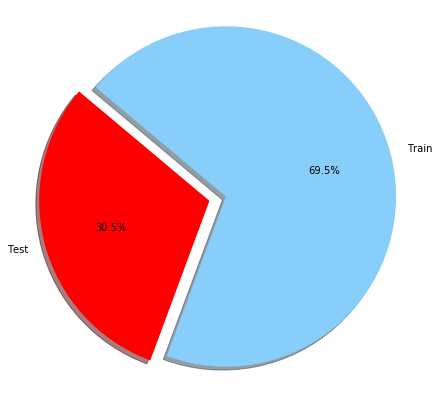

In [0]:
train_count= 0 
test_count= 0  

for filename in listdir('train_images'):
    #counting number of images in train folder
    train_count+=1 
for filename in listdir('test_images'):
    #counting number of images in test folder
    test_count+=1

print("Number of images in the train folder: ",train_count)
print("Number of images in the test folder: ",test_count)
print('-'*100)

#Pie-chart https://pythonspot.com/matplotlib-pie-chart/
# Data to plot
labels = 'Test', 'Train'
sizes = [test_count,train_count]
colors = ['red','lightskyblue']
explode = (0.1, 0)  # explode 1st slice

# Plot
plt.figure(figsize=(7,7))
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')
plt.show()

#### Looks like there is difference in image count in train folder & the imageID in train.csv

In [0]:
print("Number of images in the train folder which do not have defects are:",(train_count-train_df.shape[0]))

Number of images in the train folder which do not have defects are: 5473


### 3.3.2 Printing few sample images containing no defects

In [0]:
# load all images in a directory
#from os import listdir
from matplotlib import image
# load all images in a directory
loaded_images = list()
defects= list(train_df.ImageId.values)
for filename in listdir('train_images'):
    if str(filename) not in defects:
# load image
        img_data = image.imread('train_images/' + filename)
# store loaded image
        loaded_images.append(img_data)

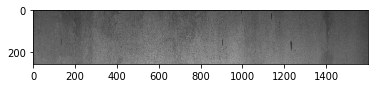

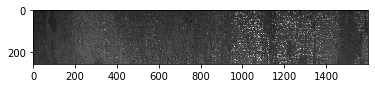

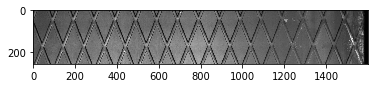

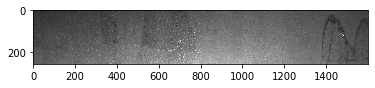

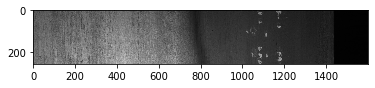

In [0]:
from matplotlib import pyplot
for i in range(5):
    disp= loaded_images[i]
    pyplot.imshow(disp)
    pyplot.show()

### 3.3.3 Basic properties of an image

In [0]:
from PIL import Image
# load the image
image = Image.open('0a5a82b86.jpg')
# summarize some details about the image
print(image.format)
print(image.mode)
print(image.size)
# show the image
image.show()

JPEG
RGB
(1600, 256)


### 3.3.4 Check if all images in train and test are of the same size

#### Train images

In [0]:
from PIL import Image
image_size=[]
for image_id in listdir('train_images'):
    img=Image.open("train_images/"+image_id)
    width,height=img.size
    image_size.append((width,height))

In [0]:
train_image_size_df=pd.DataFrame(image_size,columns=["width","height"])
train_image_size_df.head()

width  height
0   1600     256
1   1600     256
2   1600     256
3   1600     256
4   1600     256

In [0]:
print(train_image_size_df.width.unique())
print(train_image_size_df.height.unique())

[1600]
[256]


#### Test images

In [0]:
from PIL import Image
image_size=[]
for image_id in listdir('test_images'):
    img=Image.open("test_images/"+image_id)
    width,height=img.size
    image_size.append((width,height))

In [0]:
test_image_size_df=pd.DataFrame(image_size,columns=["width","height"])
test_image_size_df.head()

width  height
0   1600     256
1   1600     256
2   1600     256
3   1600     256
4   1600     256

In [0]:
print(test_image_size_df.width.unique())
print(test_image_size_df.height.unique())

[1600]
[256]


**Therefore all images in train and test folders have the same size of (1600,256)**

## 3.4 Analysis of response label: ClassId

### 3.4.1 Checking for class count

In [0]:
counts= train_df.ClassId.value_counts()
counts

3    5150
1     897
4     801
2     247
Name: ClassId, dtype: int64

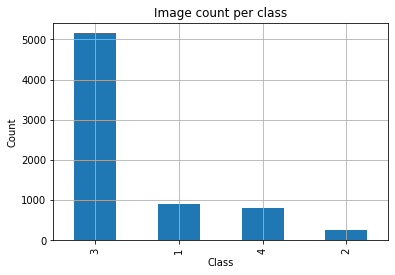

Number of images in class 3 : 5150 ( 72.586 %)
Number of images in class 1 : 897 ( 12.643 %)
Number of images in class 4 : 801 ( 11.29 %)
Number of images in class 2 : 247 ( 3.481 %)


In [0]:
my_colors = 'rgbkymc'
counts.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Image count per class')
plt.grid()
plt.show()

# ref: argsort https://docs.scipy.org/doc/numpy/reference/generated/numpy.argsort.html
# -(train_class_distribution.values): the minus sign will give us in decreasing order
sorted_counts = np.argsort(-counts.values)
for i in sorted_counts:
    k=[3,1,4,2]
    print('Number of images in class', k[i], ':',counts.values[i], '(', np.round((counts.values[i]/train_df.shape[0]*100), 3), '%)')

**Observations:**
- Number of images with class 3 defect is found to be maximum compared to other defect classes
- Images with class 2 defects are least found
- Therefore the dataset is imbalanced with dominance of Class 3 defects**

#### 3.4.1.1 Finding class weights

In [0]:
#https://scikit-learn.org/stable/modules/generated/sklearn.utils.class_weight.compute_class_weight.html
from sklearn.utils import class_weight
class_wts = class_weight.compute_class_weight('balanced', np.unique(train_df.ClassId.values),train_df.ClassId)
print(class_wts)
for i in range(len(class_wts)):
    print("Weight for class {}: {}".format(i+1,class_wts[i]))

[1.97742475 7.18117409 0.34441748 2.21441948]
Weight for class 1: 1.9774247491638797
Weight for class 2: 7.181174089068826
Weight for class 3: 0.34441747572815534
Weight for class 4: 2.2144194756554305


**Will be using these weights during training in the fit_generator function.**

### 3.4.2 Checking number of labels tagged to each image

In [0]:
labels_per_image = train_df.groupby('ImageId')['ClassId'].count()
labels_per_image.value_counts()

1    6239
2     425
3       2
Name: ClassId, dtype: int64

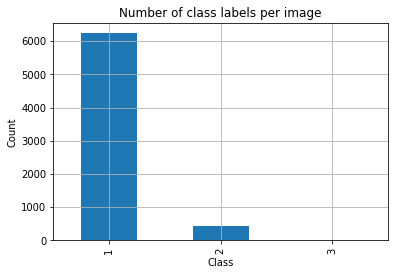

In [0]:
my_colors = 'rgbkymc'
labels_per_image.value_counts().plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Number of class labels per image')
plt.grid()
plt.show()

**Observations:**
- There are 6239 steel sheet images possessing only one class of defect i.e. either 1,2,3 or 4
- There are 425 steel sheet images possessing a combination of 2 classes defects
- There are 2 steel sheet images possessing a combination of 3 classes defects
- There are no steel sheet images possessing a combination of 4 classes defects

### 3.4.3 Displaying few sample images belonging to each of the 4 classes

In [0]:
d1= train_df[train_df.ClassId==1]
d2= train_df[train_df.ClassId==2]
d3= train_df[train_df.ClassId==3]
d4= train_df[train_df.ClassId==4]

In [0]:
d1.head()

ImageId  ClassId                                      EncodedPixels
0   0002cc93b.jpg        1  29102 12 29346 24 29602 24 29858 24 30114 24 3...
2   000a4bcdd.jpg        1  37607 3 37858 8 38108 14 38359 20 38610 25 388...
8   002fc4e19.jpg        1  146021 3 146275 10 146529 40 146783 46 147038 ...
18  008ef3d74.jpg        1  356336 4 356587 11 356838 18 357089 25 357340 ...
21  00ac8372f.jpg        1  101742 3 101998 12 102253 19 102301 22 102509 ...

#### Class-1

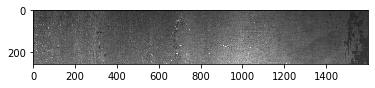

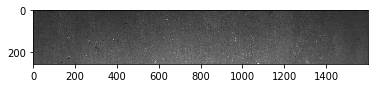

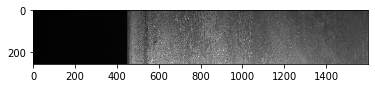

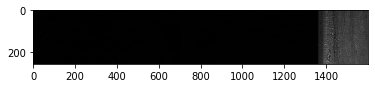

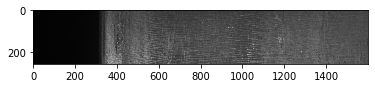

In [0]:
# load all images in a directory

from matplotlib import image
loaded_images = list()
img_names= list(d1.ImageId.values)
for filename in listdir('train_images'):
    if str(filename) in img_names:
# load image
        img_data = image.imread('train_images/' + filename)
# store loaded image
        loaded_images.append(img_data)

#displaying images
from matplotlib import pyplot
for i in range(5):
    disp= loaded_images[i]
    pyplot.imshow(disp)
    pyplot.show()

#### Class-2

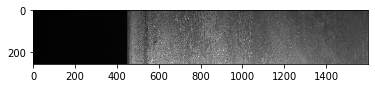

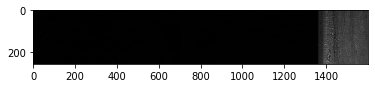

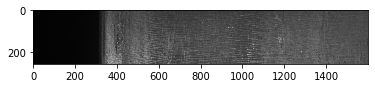

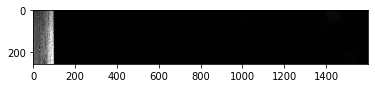

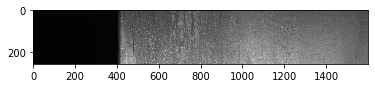

In [0]:
# load all images in a directory
loaded_images = list()
img_names= list(d2.ImageId.values)
for filename in listdir('train_images'):
    if str(filename) in img_names:
# load image
        img_data = image.imread('train_images/' + filename)
# store loaded image
        loaded_images.append(img_data)

#displaying images
from matplotlib import pyplot
for i in range(5):
    disp= loaded_images[i]
    pyplot.imshow(disp)
    pyplot.show()

#### Class-3

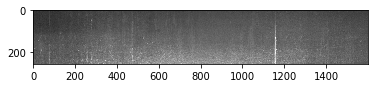

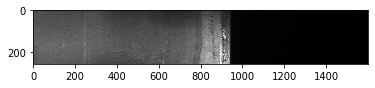

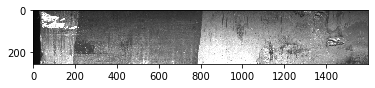

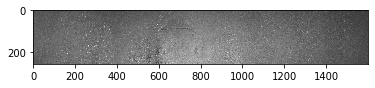

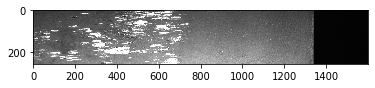

In [0]:
# load all images in a directory
loaded_images = list()
img_names= list(d3.ImageId.values)
for filename in listdir('train_images'):
    if str(filename) in img_names:
# load image
        img_data = image.imread('train_images/' + filename)
# store loaded image
        loaded_images.append(img_data)

#displaying images
from matplotlib import pyplot
for i in range(5):
    disp= loaded_images[i]
    pyplot.imshow(disp)
    pyplot.show()

#### Class-4

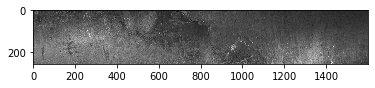

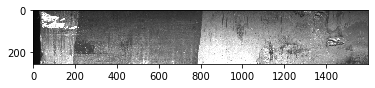

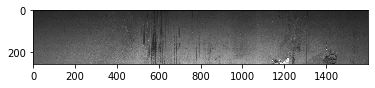

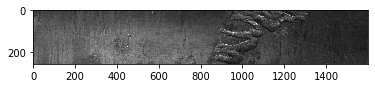

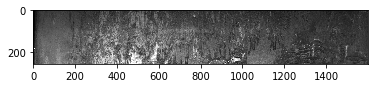

In [0]:
# load all images in a directory
loaded_images = list()
img_names= list(d4.ImageId.values)
for filename in listdir('train_images'):
    if str(filename) in img_names:
# load image
        img_data = image.imread('train_images/' + filename)
# store loaded image
        loaded_images.append(img_data)

#displaying images
from matplotlib import pyplot
for i in range(5):
    disp= loaded_images[i]
    pyplot.imshow(disp)
    pyplot.show()

# 4.0 Data preparation

## 4.1 Preparing defect data for each image

In [0]:
# preparing a dataframe with each image ID being represented with 4 classes
images= []
class_id= []
for img in listdir('train_images'):
    images.append(img)
    class_id.append(1)
    images.append(img)
    class_id.append(2)
    images.append(img)
    class_id.append(3)
    images.append(img)
    class_id.append(4)
train_images= pd.DataFrame(images,columns=['ImageId'])
train_images['ClassId'] = class_id
train_images.head()

ImageId  ClassId
0  0002cc93b.jpg        1
1  0002cc93b.jpg        2
2  0002cc93b.jpg        3
3  0002cc93b.jpg        4
4  00031f466.jpg        1

In [0]:
train_images.shape

(50272, 2)

In [0]:
# Dataframe containing RLE(run length encoded pixels) representing defects
train_df.head()

ImageId  ClassId                                      EncodedPixels
0  0002cc93b.jpg        1  29102 12 29346 24 29602 24 29858 24 30114 24 3...
1  0007a71bf.jpg        3  18661 28 18863 82 19091 110 19347 110 19603 11...
2  000a4bcdd.jpg        1  37607 3 37858 8 38108 14 38359 20 38610 25 388...
3  000f6bf48.jpg        4  131973 1 132228 4 132483 6 132738 8 132993 11 ...
4  0014fce06.jpg        3  229501 11 229741 33 229981 55 230221 77 230468...

In [0]:
# merging defect & non-defect data
temp_df = pd.merge(train_images, train_df,how='outer',on=['ImageId','ClassId'])
temp_df = temp_df.fillna('')
print(temp_df.shape)
temp_df.head()

(50272, 3)


ImageId  ClassId                                      EncodedPixels
0  0002cc93b.jpg        1  29102 12 29346 24 29602 24 29858 24 30114 24 3...
1  0002cc93b.jpg        2                                                   
2  0002cc93b.jpg        3                                                   
3  0002cc93b.jpg        4                                                   
4  00031f466.jpg        1

In [0]:
# Grouping the data according to ImageID with each row representing images with single or multiple defects 
#https://www.geeksforgeeks.org/python-pandas-pivot_table/

defect_data = pd.pivot_table(temp_df, values='EncodedPixels', index='ImageId',columns='ClassId', aggfunc=np.sum).astype(str)
defect_data = defect_data.reset_index()
defect_data.columns = ['ImageId','Defect_1','Defect_2','Defect_3','Defect_4']
defect_data.head()

ImageId                                           Defect_1 Defect_2  \
0  0002cc93b.jpg  29102 12 29346 24 29602 24 29858 24 30114 24 3...            
1  00031f466.jpg                                                               
2  000418bfc.jpg                                                               
3  000789191.jpg                                                               
4  0007a71bf.jpg                                                               

                                            Defect_3 Defect_4  
0                                                              
1                                                              
2                                                              
3                                                              
4  18661 28 18863 82 19091 110 19347 110 19603 11...

In [0]:
defect_data.shape

(12568, 5)

## 4.2 Splitting the data into train & CV

In [0]:
from sklearn.model_selection import train_test_split
data= defect_data
train_data, cv_data = train_test_split(data, test_size=0.15)
print(train_data.shape)
print(cv_data.shape)

(10682, 5)
(1886, 5)


# 5.0 Utility functions

## 5.1 Mask encoding and decoding

In [0]:
# to convert masks to run length encoded values
#https://www.kaggle.com/aleksandradeis/steel-defect-detection-eda

def mask2rle(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [0]:
# to convert run length encoded pixels to masks
#https://www.kaggle.com/aleksandradeis/steel-defect-detection-eda
def rle2mask(rle):
    '''
    Returns mask array by converting run length encoded pixels
    
    '''
  # If rle is empty or null
    if(len(rle)<1): 
        return np.zeros((128,800) ,dtype=np.uint8)
    
    height = 256
    width = 1600
    # Defining the length of mask. This will be a 1d array which will be reshaped to 2d later.
    mask = np.zeros(height*width ).astype(np.uint8)
    array = np.asarray([int(x) for x in rle.split()]) # array containing rle
    start = array[0::2]-1 # this willl contain the start of run length
    length = array[1::2] # this will contain the length of each rle.
    for i,start in enumerate(start):
        mask[int(start):int(start+length[i])] = 1
    return mask.reshape( (height,width), order='F' )[::2,::2]

## 5.2 Custom metric and loss function

In [0]:
from keras import backend as K
from keras.losses import binary_crossentropy
#https://lars76.github.io/neural-networks/object-detection/losses-for-segmentation/
#https://www.kaggle.com/wh1tezzz/correct-dice-metrics-for-this-competition
#https://forums.fast.ai/t/understanding-the-dice-coefficient/5838

def dice_coef(y_true, y_pred, smooth=1):
    ''' Function that returns dice coefficient by taking input masks and predicted masks'''
    
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
  
def  bce_dice_loss(y_true, y_predict): #combination of dice loss and binary cross entropy for all pixels
    return binary_crossentropy(y_true, y_predict) + (1-dice_coef(y_true, y_predict))

## 5.3 Training Plots

In [0]:
from matplotlib import pyplot
def plot(history):
    '''function to plot epoch vs bce_dice_loss & epoch vs dice_coeff '''
    # plot bce_dice_loss
    pyplot.subplot(121)
    pyplot.title('bce_dice_loss')
    pyplot.xlabel('Epoch')
    pyplot.plot(history.history['loss'], color='blue', label='train')
    pyplot.plot(history.history['val_loss'], color='orange', label='CV')
    # plot dice_coeff
    pyplot.subplot(122)
    pyplot.title('Dice_coef')
    pyplot.xlabel('Epoch')
    pyplot.plot(history.history['dice_coef'], color='blue', label='train')
    pyplot.plot(history.history['val_dice_coef'], color='orange', label='CV')

## 5.4 Visualizing defects on train & validation images

In [0]:
def visualize_defects(data,model):
    ''' Function that takes data containing imageID's ,model and outputs 4 masks for each image '''
    
    import random
    image_id= list(data.ImageId.values)
    for i in random.sample(image_id, 5):
        df= data[data.ImageId==i]
        X = np.empty((1,128,800,3),dtype=np.float32)
        img = cv2.imread('/content/' +'train_images/' + i)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (800,128))
        X[0,] = img
        mask_pred = model.predict(X)
        fig, axs = plt.subplots(4,3,figsize=(18, 7))
        axs[0,0].imshow(img)
        axs[0,0].set_title(i)
        for j in range(4):
            
            if j<3:
                axs[j+1,0].axis('off')
            k=0
            gt= rle2mask(df.iloc[0][j+1])
            m = mask_pred[0,:,:,j].round().astype(int)
            axs[j,k+1].imshow(gt)
            axs[j,k+1].set_title('Ground truth mask: Class_'+str(j+1))
            axs[j,k+2].imshow(m)
            axs[j,k+2].set_title('Predicted mask: Class_'+str(j+1))
        plt.show()
        print('-'*100)

## 5.5 Visualizing defects on raw test images

In [0]:
def visualize_defects_test(data,n):
    
    ''' Function that takes test ImageID's and the number of images to display as input and therefore outputs 
    mask with class ID'''
    
    data= data[data['EncodedPixels']!='']
    for i in random.sample(list(data['ImageId_ClassId'].values), n): 
        df= data[data.ImageId_ClassId==i]
        img = Image.open('/content/' +'test_images/' + i.split('_')[0])
        pixels= df.iloc[0][1]
        mask= rle2mask(pixels)
        fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15, 7))
        ax1.imshow(img)
        ax1.set_title(i.split('_')[0])
        ax2.imshow(mask)
        ax2.set_title('Predicted mask with Class-'+i.split('_')[1]+' defect.')
        plt.show()
        print('-'*150)

# 6.0 Check rle2mask function and visualize few masks & images

Sample images with Class 1 defect:


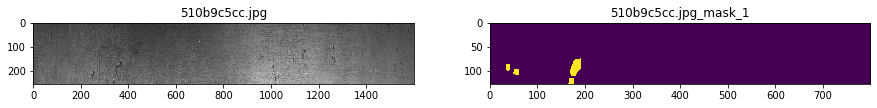

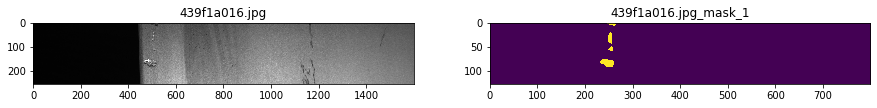

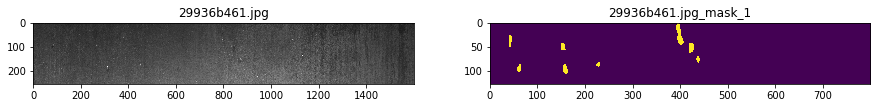

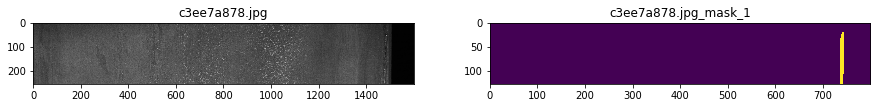

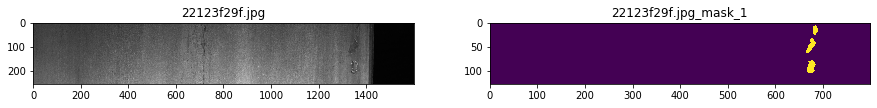

----------------------------------------------------------------------------------------------------
Sample images with Class 2 defect:


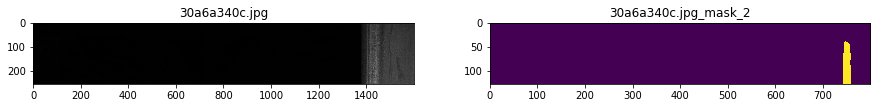

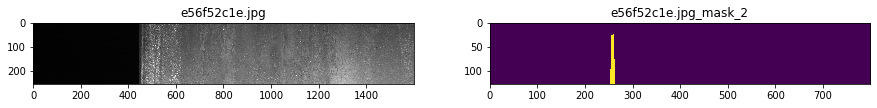

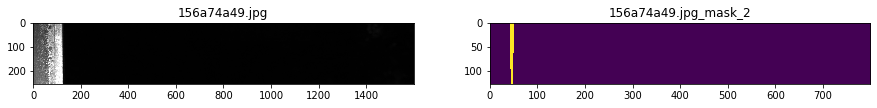

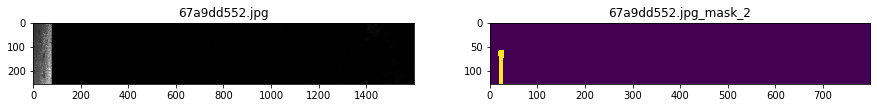

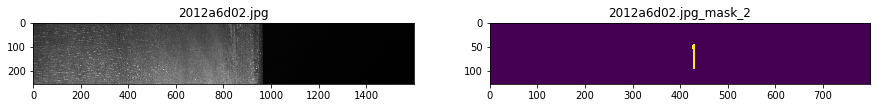

----------------------------------------------------------------------------------------------------
Sample images with Class 3 defect:


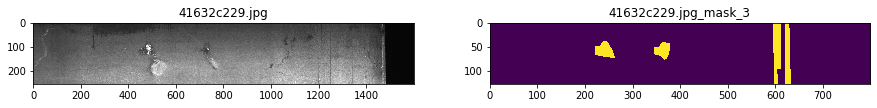

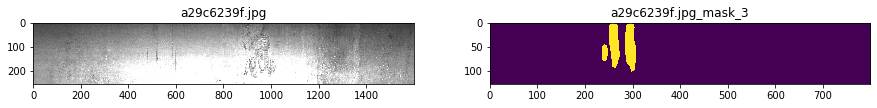

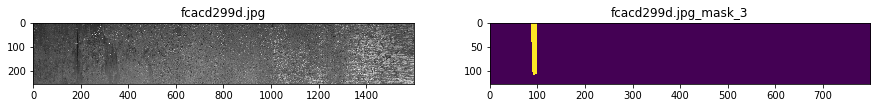

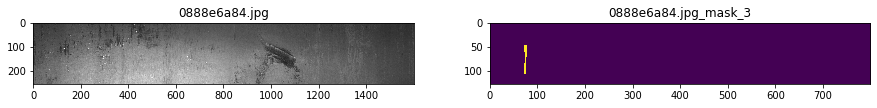

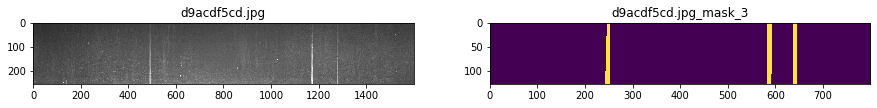

----------------------------------------------------------------------------------------------------
Sample images with Class 4 defect:


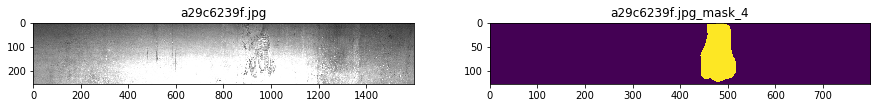

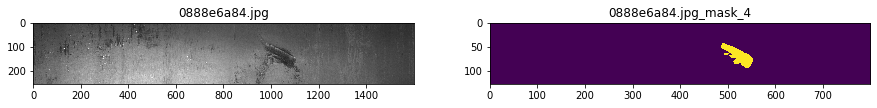

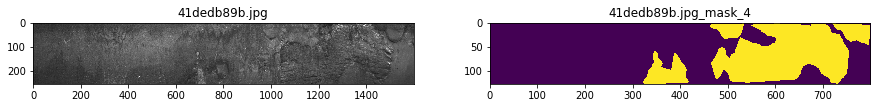

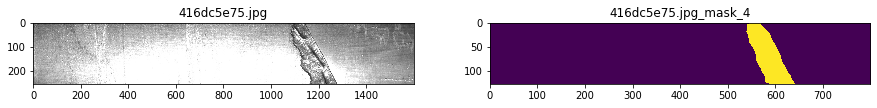

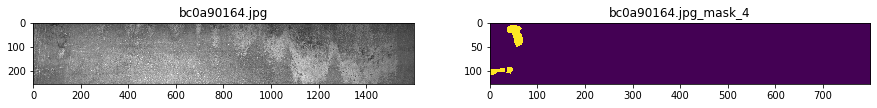

----------------------------------------------------------------------------------------------------


In [0]:
for k in [1,2,3,4]: #classes
    tmp = []
    cnt=0
    print("Sample images with Class {} defect:".format(k))
    for i in train_data[train_data[f'Defect_{k}']!=''][['ImageId',f'Defect_{k}']].values:
        if cnt<5:
            fig, (ax1,ax2) = plt.subplots(nrows = 1,ncols = 2,figsize=(15, 7))
            img = Image.open('train_images/' + str(i[0]))
            ax1.imshow(img)
            ax1.set_title(i[0])
            cnt+=1
            ax2.imshow(rle2mask(i[1]))
            ax2.set_title(i[0]+'_mask_'+str(k))
            plt.show()
    print('-'*100)

# 7.0 Generating data for Keras model

## 7.1 Train generator

In [0]:
# https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly
# https://keras.io/preprocessing/image/

import keras
from keras.preprocessing.image import ImageDataGenerator
class Train_DataGenerator(keras.utils.Sequence):
    def __init__(self, df, batch_size = 16,shuffle=False, 
                 preprocess=None, info={}):
        super().__init__()
        self.df = df
        self.shuffle = shuffle
        self.batch_size = batch_size
        self.preprocess = preprocess
        self.info = info
        self.data_path = '/content/' + 'train_images/'
        self.on_epoch_end()
        
    def __len__(self):
        return int(np.floor(len(self.df) / self.batch_size))
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.df))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    
    def __getitem__(self, index):
        train_datagen = ImageDataGenerator()
        param = {'flip_horizontal':True, 'flip_vertical' : True}
        '''' 
        Performing data augmentation on images and the masks generated which includes Horizontal flip &  Vertical flip
        
        '''
        X = np.empty((self.batch_size,128,800,3),dtype=np.float32) #images
        y = np.empty((self.batch_size,128,800,4),dtype=np.int8)    #masks
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        for i,f in enumerate(self.df['ImageId'].iloc[indexes]):
            self.info[index*self.batch_size+i]=f
            img = Image.open(self.data_path + f).resize((800,128))
            X[i,] = train_datagen.apply_transform(x = img, transform_parameters = param)
                #run-length encoding on the pixel values
            for j in range(4):
                mask= rle2mask(self.df['Defect_'+str(j+1)].iloc[indexes[i]])
                y[i,:,:,j] = train_datagen.apply_transform(x = mask, transform_parameters = param)
        if self.preprocess!=None: X = self.preprocess(X)
        return X, y

## 7.2 Validation generator(Without Augmentation)

In [0]:
# https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly

import keras
from keras.preprocessing.image import ImageDataGenerator
class Val_DataGenerator(keras.utils.Sequence):
    def __init__(self, df, batch_size = 16,shuffle=False, 
                 preprocess=None, info={}):
        super().__init__()
        self.df = df
        self.shuffle = shuffle
        self.batch_size = batch_size
        self.preprocess = preprocess
        self.info = info
        self.data_path = '/content/' + 'train_images/'
        self.on_epoch_end()
        
    def __len__(self):
        return int(np.floor(len(self.df) / self.batch_size))
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.df))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
            
    def __getitem__(self, index):
        
        X = np.empty((self.batch_size,128,800,3),dtype=np.float32) #images
        y = np.empty((self.batch_size,128,800,4),dtype=np.int8)    #masks
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        for i,f in enumerate(self.df['ImageId'].iloc[indexes]):
            self.info[index*self.batch_size+i]=f
            X[i,] = Image.open(self.data_path + f).resize((800,128))
            #run-length encoding on the pixel values
            for j in range(4):
                y[i,:,:,j] = rle2mask(self.df['Defect_'+str(j+1)].iloc[indexes[i]])
        if self.preprocess!=None: X = self.preprocess(X)
        return X, y

<h1 style="text-align:center;font-size:40px;" > Implementing Segmentation Architectures </h1>

# 1.0 Basic U-NET (First-cut approach)

![alt text](https://drive.google.com/uc?id=1eS1GuAldhs-KYK-RQ6lKO7jTyGgm3hcN)

**References-**
- https://towardsdatascience.com/understanding-semantic-segmentation-with-unet-6be4f42d4b47

In [0]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

In [0]:
def get_unet(input_img, n_filters, dropout, batchnorm):
    
    """Function to define the UNET architecture"""
    
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(4, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [0]:
input_img = Input((128, 800, 3), name='img')
model = get_unet(input_img, n_filters=8, dropout=0.2, batchnorm=True)
model.compile(optimizer=Adam(), loss=bce_dice_loss, metrics=[dice_coef])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 128, 800, 3)  0                                            
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 128, 800, 8)  224         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_19 (BatchNo (None, 128, 800, 8)  32          conv2d_20[0][0]                  
__________________________________________________________________________________________________
activation_19 (Activation)      (None, 128, 800, 8)  0           batch_normalization_19[0][0]     
____________________________________________________________________________________________

## 1.1 Checkpointing the model and creating the callback list

In [0]:
from keras.callbacks import ModelCheckpoint
from keras.callbacks import CSVLogger
import matplotlib.pyplot as plt
from tensorflow.python.keras.callbacks import TensorBoard
from keras.callbacks import TensorBoard
import tensorflow as tf
import datetime
import keras
from tensorboardcolab import *
from keras.callbacks import ReduceLROnPlateau

#https://github.com/taomanwai/tensorboardcolab/
tbc=TensorBoardColab()
#https://machinelearningmastery.com/check-point-deep-learning-models-keras/
mc = ModelCheckpoint('best_model_unet.h5', monitor='val_dice_coef', verbose=1, save_best_only=True, mode='max')
callbacks_list = [mc, TensorBoardColabCallback(tbc)]

Wait for 8 seconds...
TensorBoard link:
https://bde24643.ngrok.io


## 1.2 Fitting the train data and validation

In [0]:
train_batches = Train_DataGenerator(train_data,shuffle=True)
valid_batches = Val_DataGenerator(cv_data)
history = model.fit_generator(train_batches, validation_data = valid_batches, epochs = 50, verbose=1,
                              class_weight= class_wts,callbacks= callbacks_list) #class_wts as clculated in EDA





Epoch 1/50
667/667 [==============================] - 235s 352ms/step - loss: 1.2888 - dice_coef: 0.0286 - val_loss: 0.9921 - val_dice_coef: 0.0688

Epoch 00001: val_dice_coef improved from -inf to 0.06879, saving model to /content/weights.best.hdf5

Epoch 2/50
667/667 [==============================] - 221s 332ms/step - loss: 0.7664 - dice_coef: 0.2798 - val_loss: 0.6661 - val_dice_coef: 0.3743

Epoch 00002: val_dice_coef improved from 0.06879 to 0.37426, saving model to /content/weights.best.hdf5
Epoch 3/50
667/667 [==============================] - 218s 327ms/step - loss: 0.6021 - dice_coef: 0.4394 - val_loss: 0.6355 - val_dice_coef: 0.4068

Epoch 00003: val_dice_coef improved from 0.37426 to 0.40684, saving model to /content/weights.best.hdf5
Epoch 4/50
667/667 [==============================] - 218s 327ms/step - loss: 0.5688 - dice_coef: 0.4727 - val_loss: 0.5948 - val_dice_coef: 0.4483

Epoch 00004: val_dice_coef improved from 0.40684 to 0.44832, saving model to /content/weig

## 1.3 Plots on training & validation results

### Loss function & metric plots

**Please refer to Training Plots in utility functions section.**

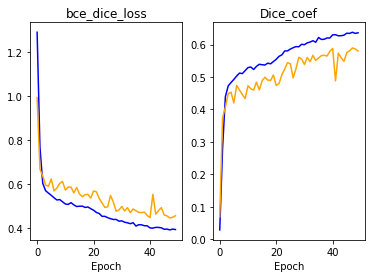

In [0]:
plot(history)

### Tensorboard images

![img](https://drive.google.com/uc?id=1c_g5vl3EzaAOp9Ll4BhaXDZ7wFO1_3ut)

![alt text](https://drive.google.com/uc?id=1zsbpaKzNvuz8QgnU9DhjAuYBG0F9-zd8)

![alt text](https://drive.google.com/uc?id=1s2LjMtm_QtRcfMQ4yVPTkOZuSKTMw-mJ)

## 1.4 Model Testing

### Loading the best model for evaluation

In [0]:
from keras.models import load_model
dependencies = {'bce_dice_loss':bce_dice_loss,'dice_coef':dice_coef,}
model_best = load_model('/content/best_model_unet.h5',custom_objects=dependencies)

### Evaluating on validation images

In [0]:
evals= model_best.evaluate(valid_batches,verbose=1)

117/117 [==============================] - 36s 306ms/step


In [0]:
print('Validation set evaluation score:')
print('bce_dice loss:',evals[0])
print('dice_coeff:',evals[1])

Validation set evaluation score:
bce_dice loss: 0.4407530933873266
dice_coeff: 0.5941144448314977


## 1.5 Defects visualization

**Please refer to the "visualize_defects" function in Utility functions section.**

### Training set

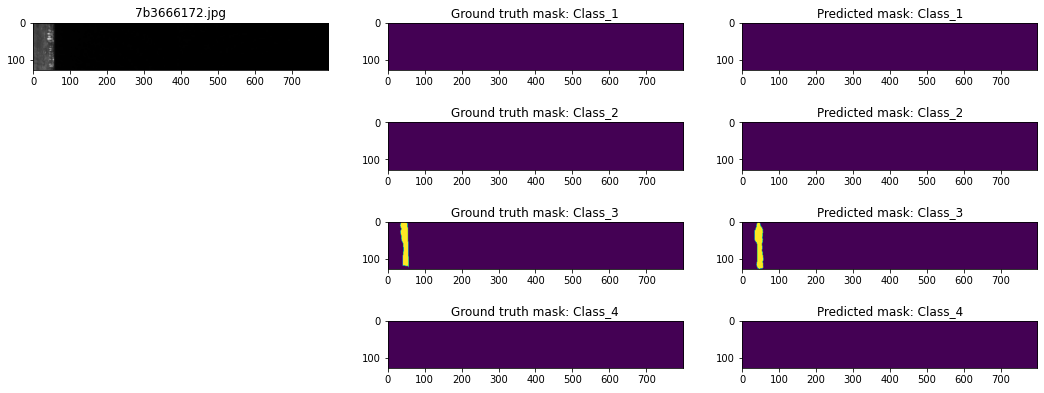

----------------------------------------------------------------------------------------------------


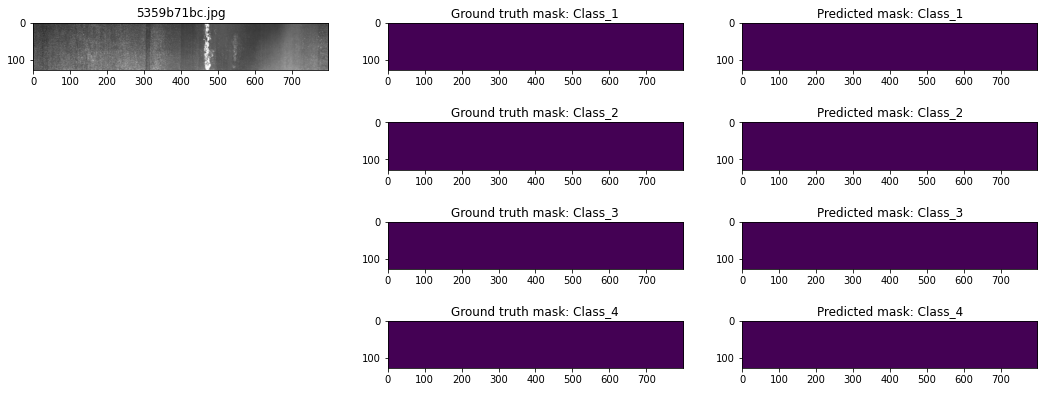

----------------------------------------------------------------------------------------------------


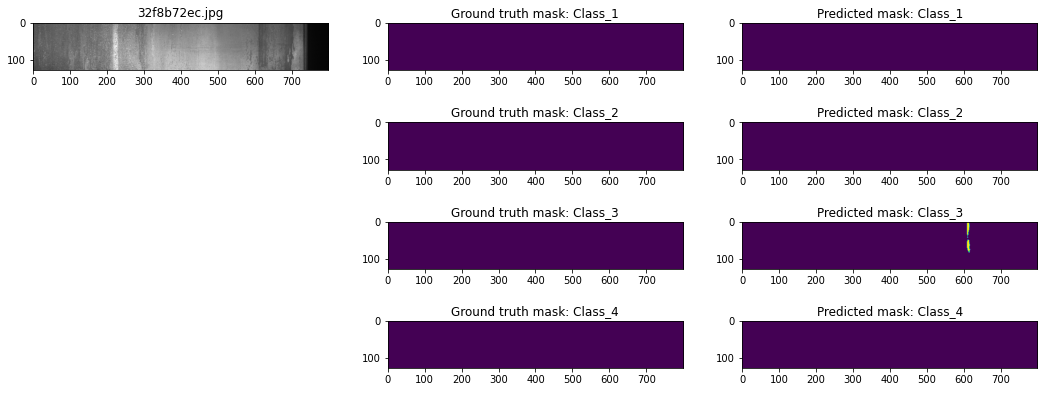

----------------------------------------------------------------------------------------------------


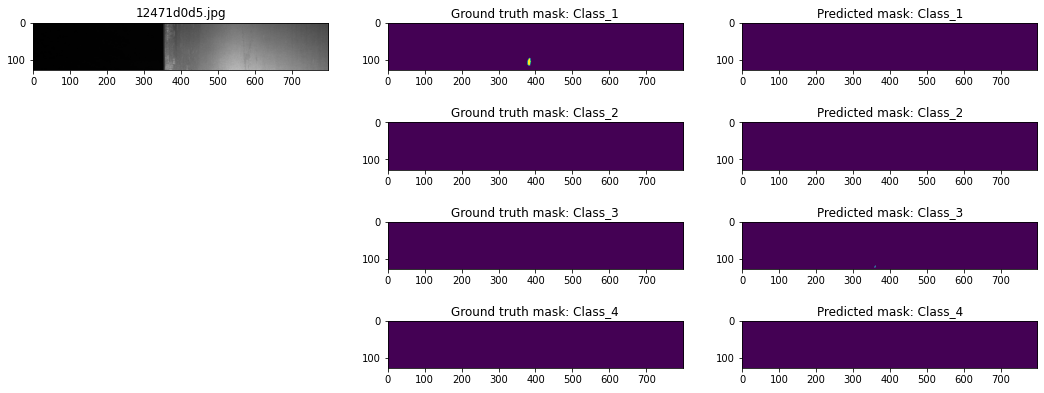

----------------------------------------------------------------------------------------------------


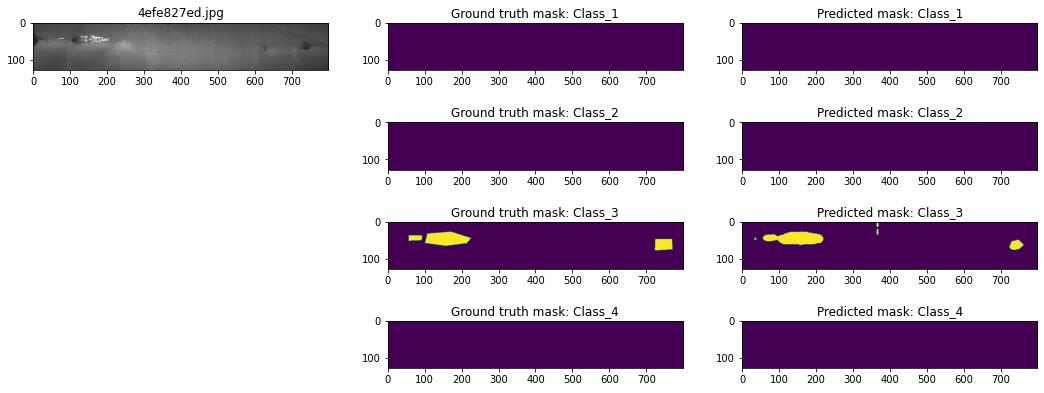

----------------------------------------------------------------------------------------------------


In [0]:
visualize_defects(train_data,model_best)

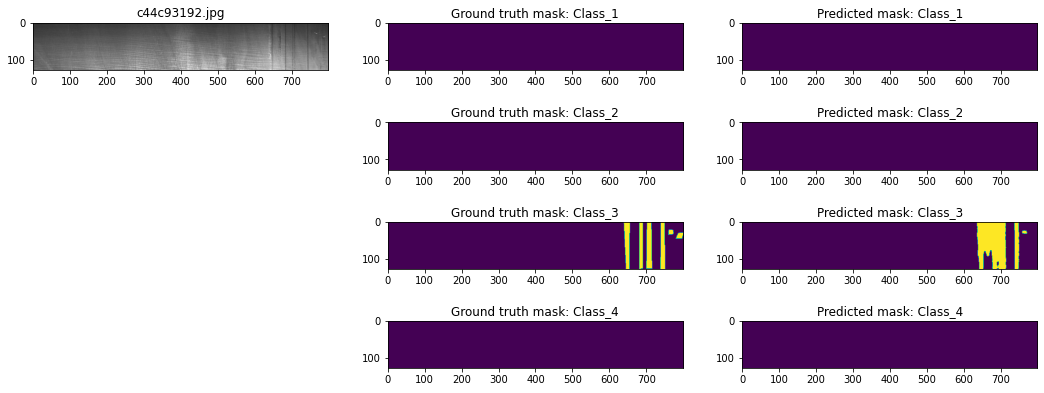

----------------------------------------------------------------------------------------------------


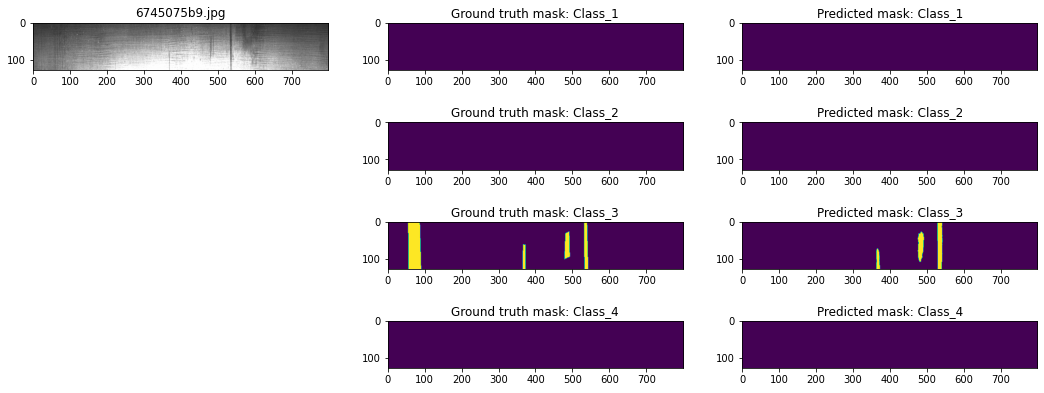

----------------------------------------------------------------------------------------------------


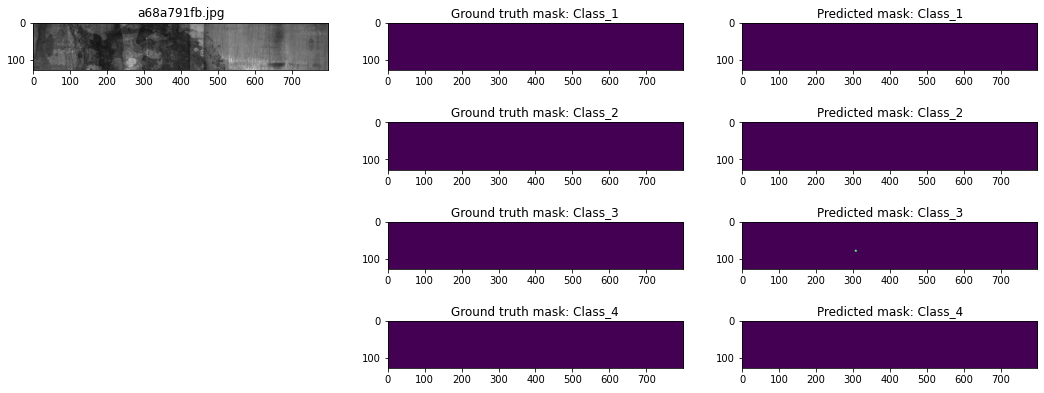

----------------------------------------------------------------------------------------------------


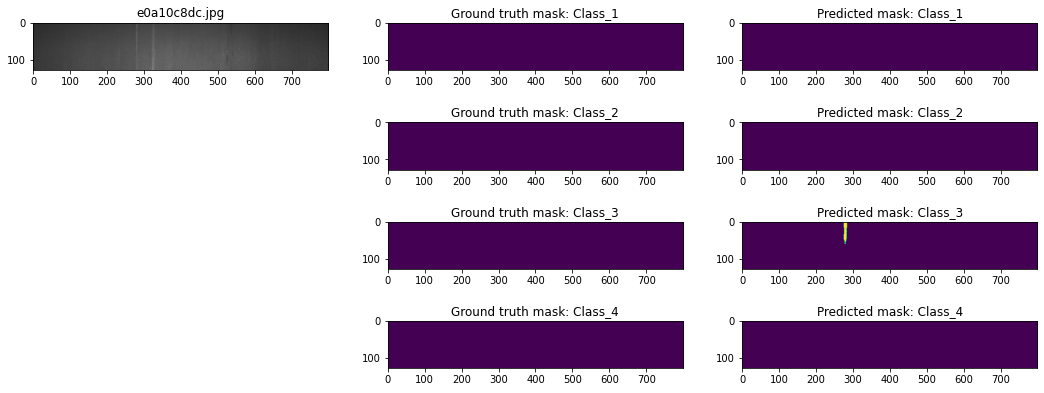

----------------------------------------------------------------------------------------------------


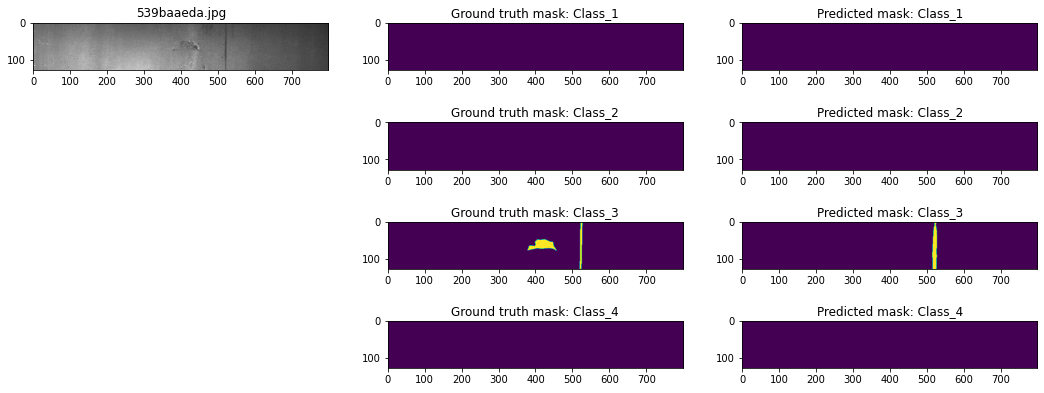

----------------------------------------------------------------------------------------------------


In [0]:
visualize_defects(train_data,model_best)

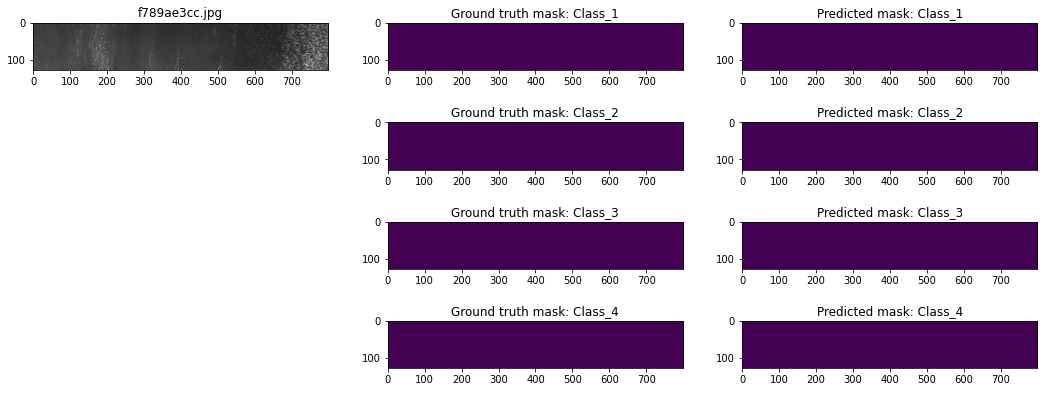

----------------------------------------------------------------------------------------------------


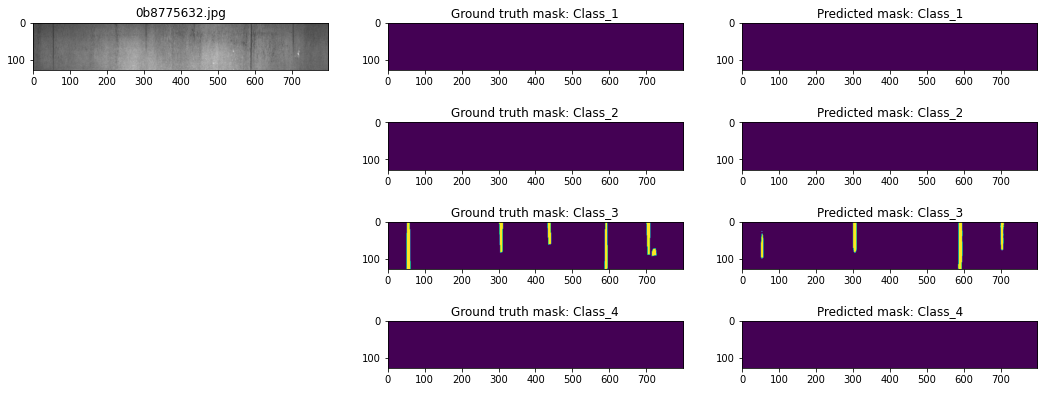

----------------------------------------------------------------------------------------------------


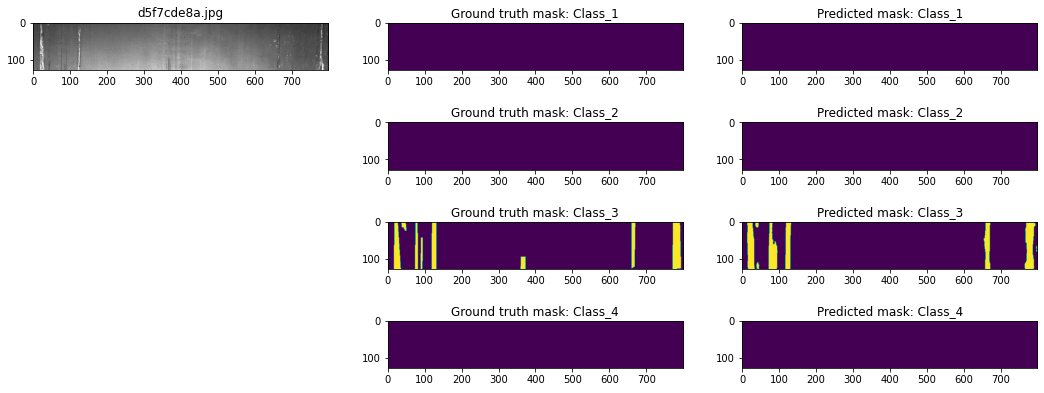

----------------------------------------------------------------------------------------------------


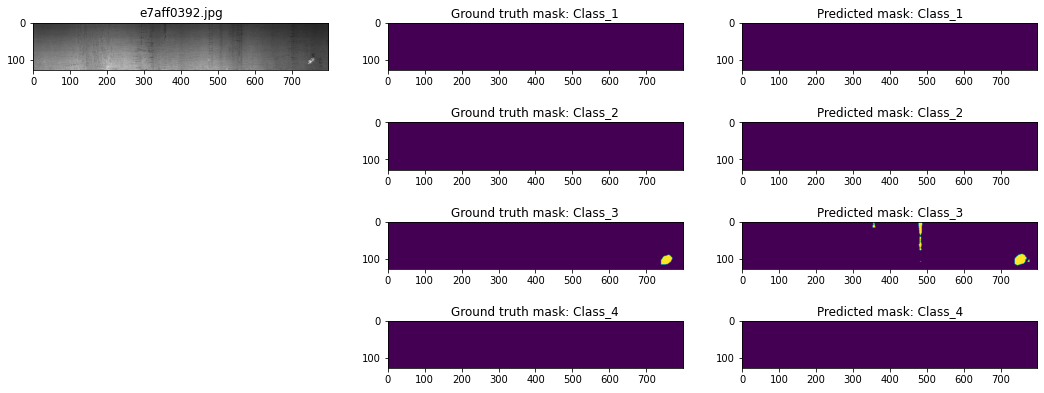

----------------------------------------------------------------------------------------------------


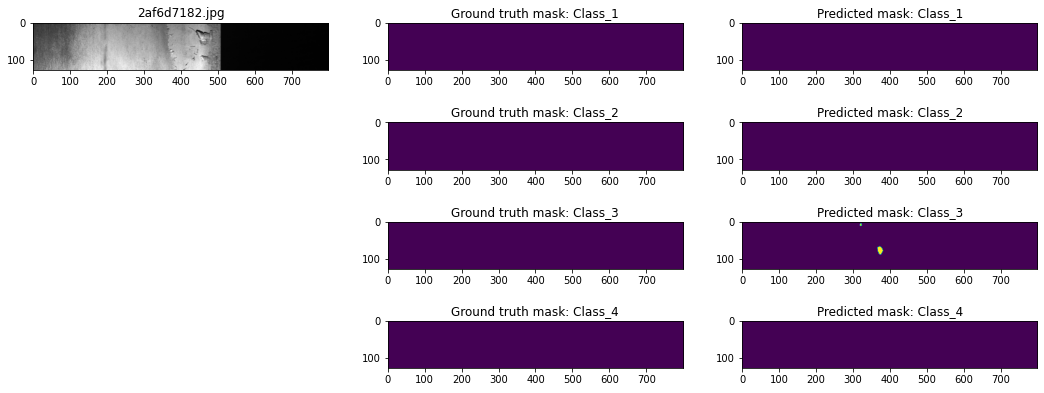

----------------------------------------------------------------------------------------------------


In [0]:
visualize_defects(train_data,model_best)

### Validation set

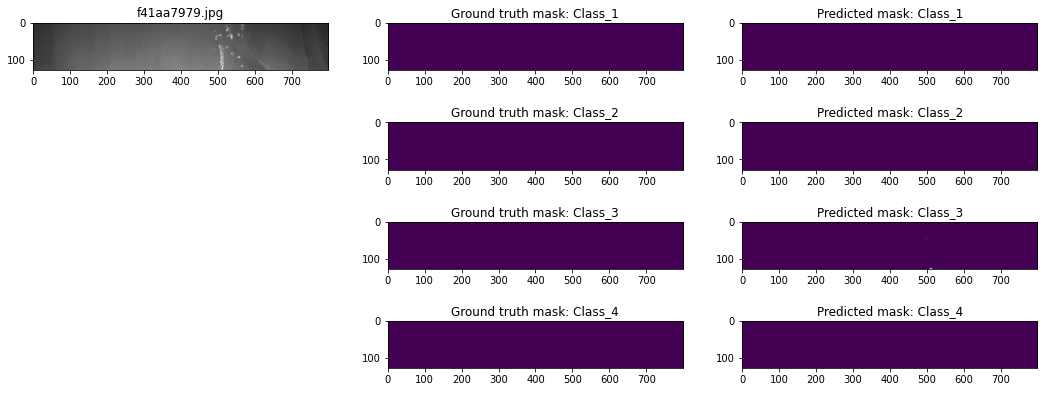

----------------------------------------------------------------------------------------------------


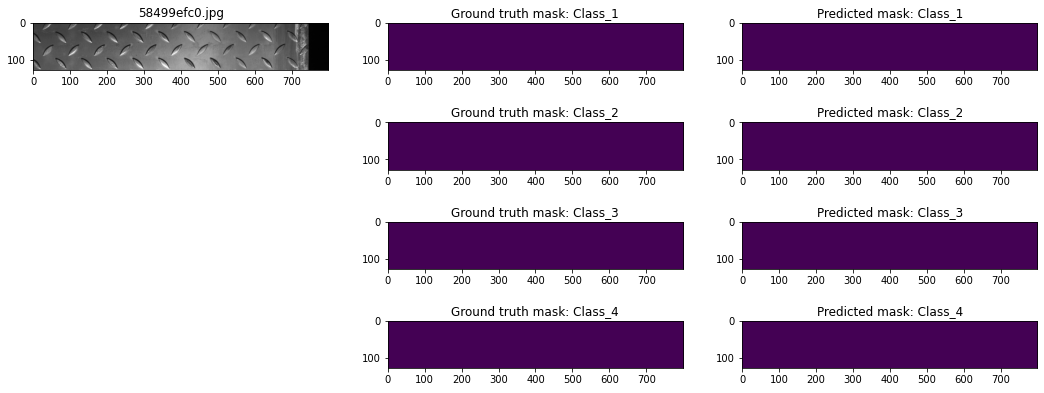

----------------------------------------------------------------------------------------------------


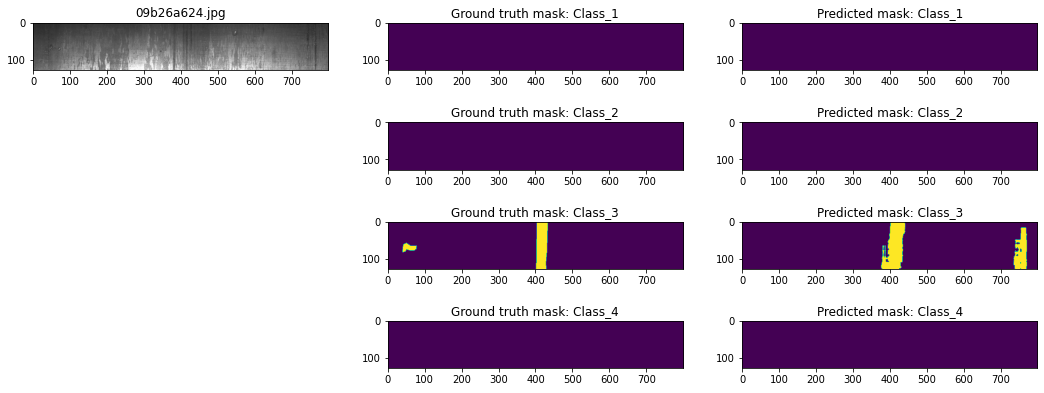

----------------------------------------------------------------------------------------------------


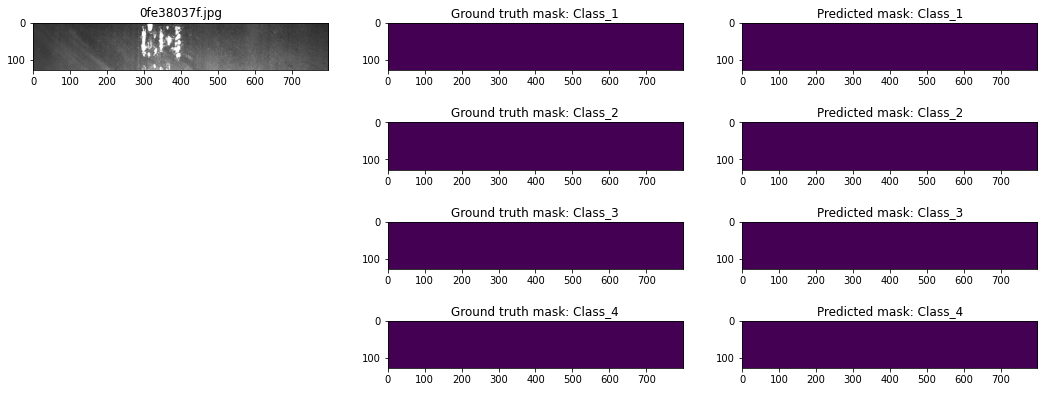

----------------------------------------------------------------------------------------------------


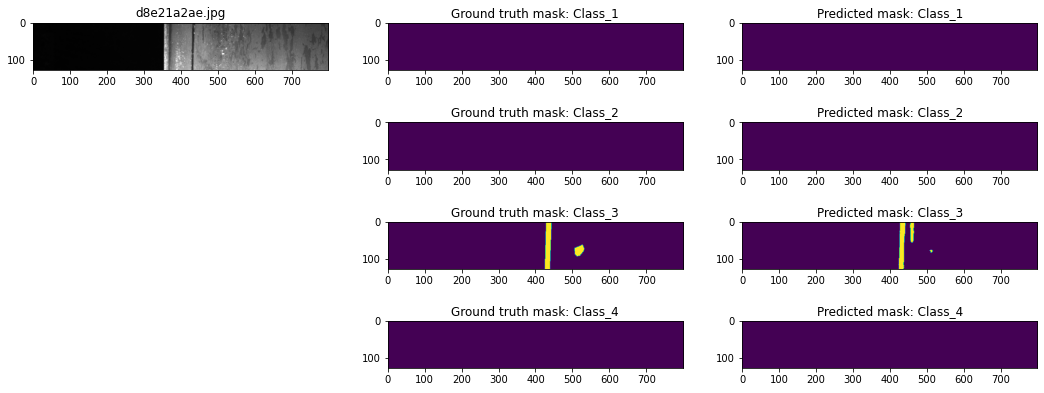

----------------------------------------------------------------------------------------------------


In [0]:
visualize_defects(cv_data,model_best)

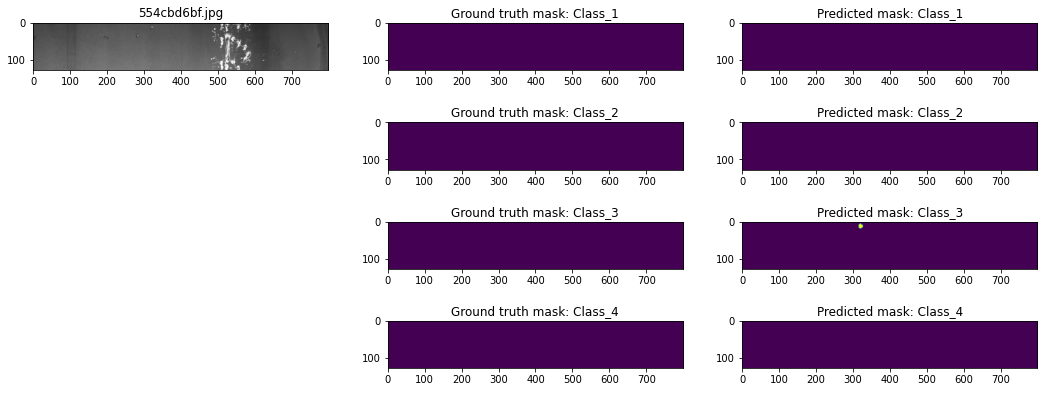

----------------------------------------------------------------------------------------------------


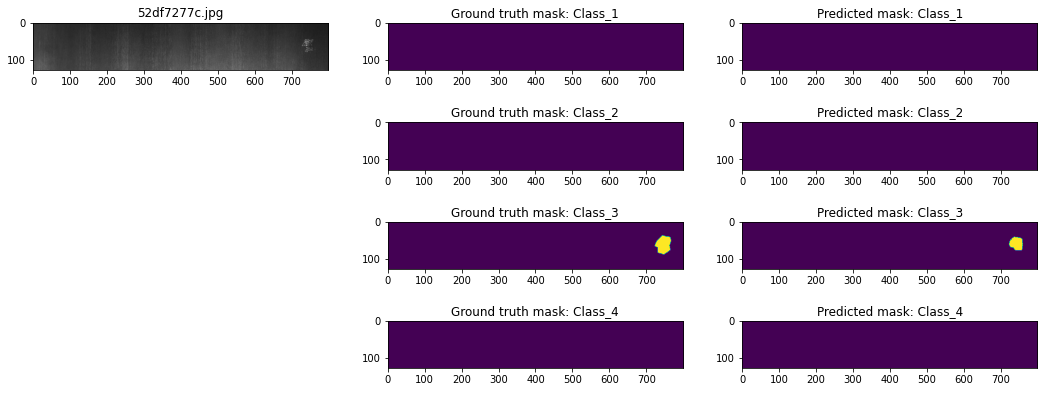

----------------------------------------------------------------------------------------------------


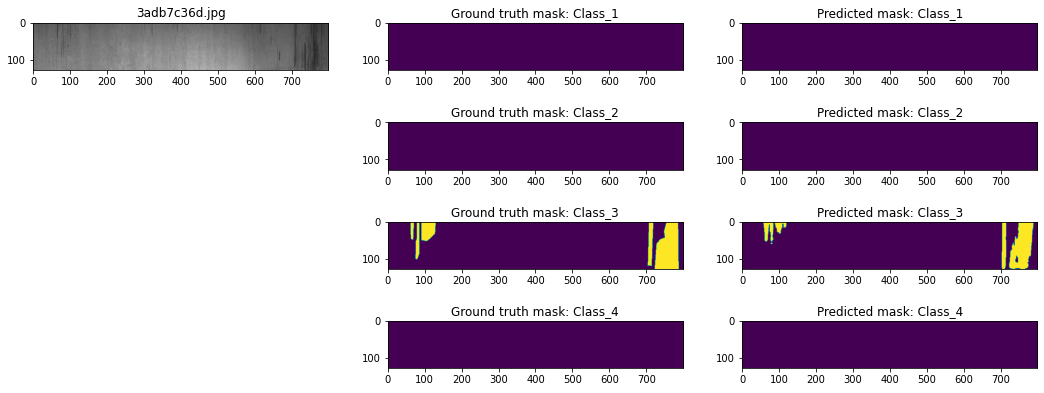

----------------------------------------------------------------------------------------------------


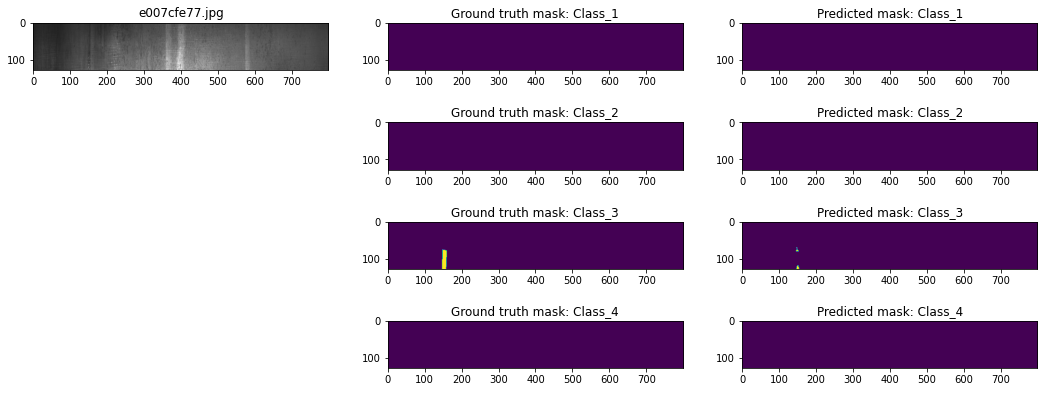

----------------------------------------------------------------------------------------------------


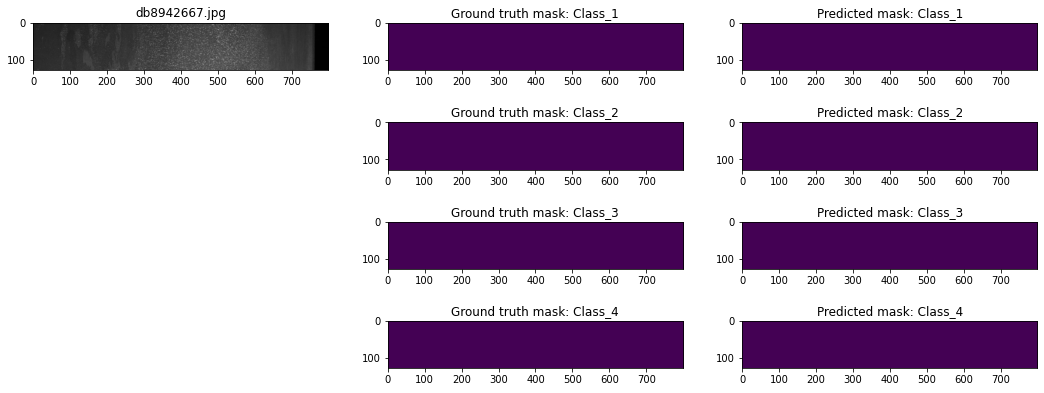

----------------------------------------------------------------------------------------------------


In [0]:
visualize_defects(cv_data,model_best)

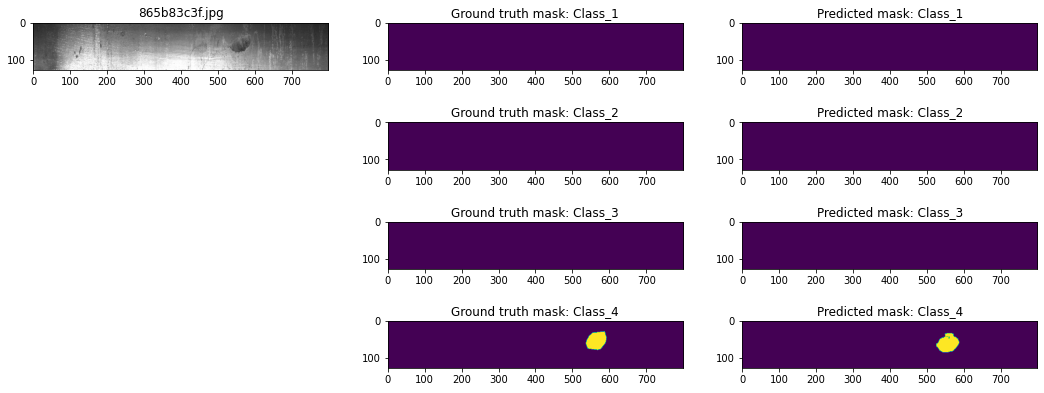

----------------------------------------------------------------------------------------------------


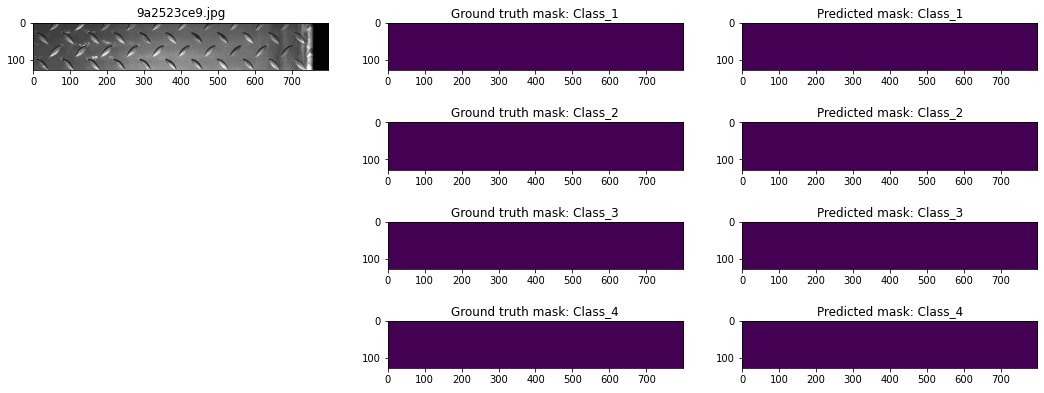

----------------------------------------------------------------------------------------------------


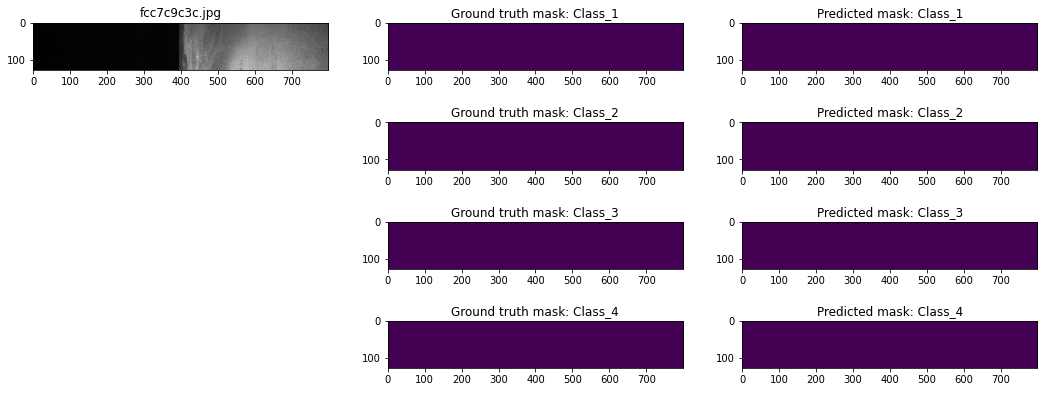

----------------------------------------------------------------------------------------------------


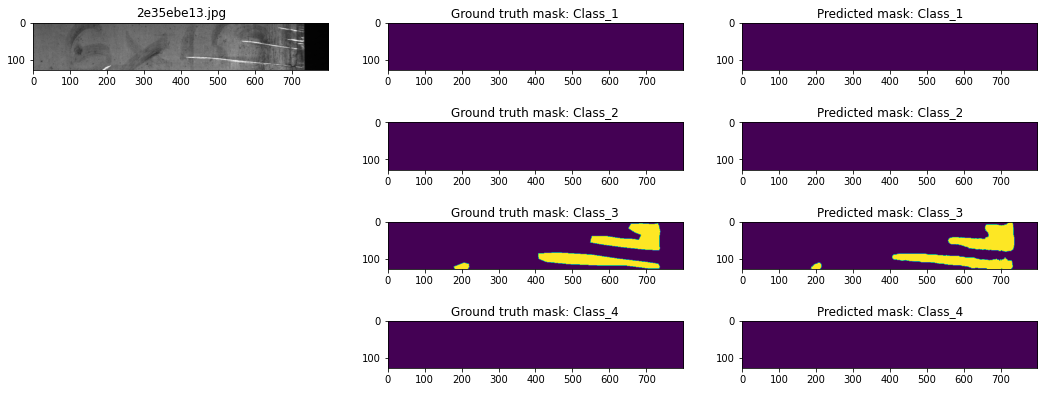

----------------------------------------------------------------------------------------------------


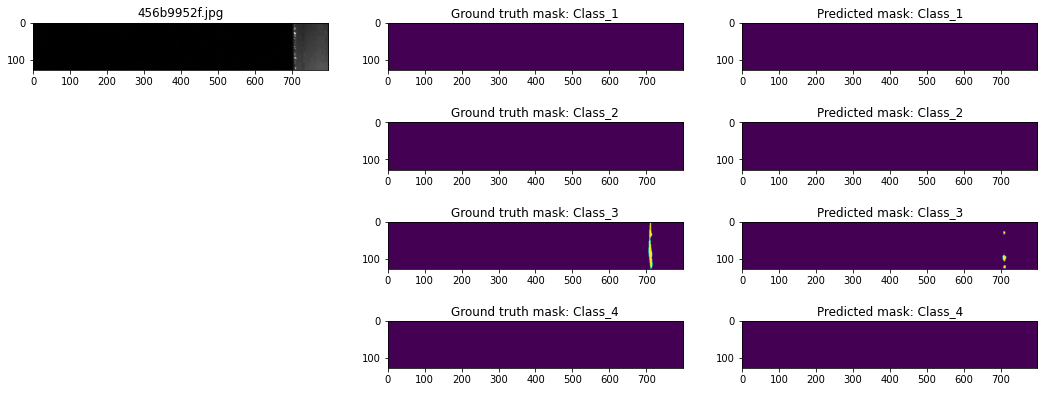

----------------------------------------------------------------------------------------------------


In [0]:
visualize_defects(cv_data,model_best)

## 1.6 Predicting defects on raw test images

### Predicting on raw test images by resizing images to 128x800 dimensions in order to apply the model

In [0]:
# Predicting on test images
from tqdm import tqdm
import cv2
data_path = '/content/' + 'test_images/'
files = list(os.listdir(data_path))
rle_lst = [] #list to store defect in run length encoding format
img_classId= [] #list to store Image ID + classId
for f in tqdm(files):
    X = np.empty((1,128,800,3),dtype=np.float32)
    img = cv2.imread(data_path + f)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (800,128))
    X[0,] = img
    mask = model_best.predict(X)
    rle_m = np.empty((128,800),dtype=np.uint8)
    for i in range(4):
        rle_m = mask[0,:,:,i].round().astype(int)
        rle = mask2rle(rle_m)
        rle_lst.append(rle)
        img_classId.append(f+'_'+str(i+1))

100%|██████████| 5506/5506 [01:29<00:00, 61.81it/s]


In [0]:
output = {'ImageId_ClassId':img_classId, 'EncodedPixels' : rle_lst}
import pandas as pd
output_df = pd.DataFrame(output)
output_df.to_csv('submission_unet_128X800.csv', index=False)

**With this submission in kaggle, I got a private dice coefficient score of 0.79814 & a public score of 0.78045.**

### Redefining the unet architecture for original image size of 256x1600

In [0]:
input_img = Input((256,1600,3), name='img')
model = get_unet(input_img, n_filters=8, dropout=0.2, batchnorm=True)
model.compile(optimizer=Adam(), loss=bce_dice_loss, metrics=[dice_coef])
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 256, 1600, 3) 0                                            
__________________________________________________________________________________________________
conv2d_39 (Conv2D)              (None, 256, 1600, 8) 224         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_37 (BatchNo (None, 256, 1600, 8) 32          conv2d_39[0][0]                  
__________________________________________________________________________________________________
activation_37 (Activation)      (None, 256, 1600, 8) 0           batch_normalization_37[0][0]     
____________________________________________________________________________________________

In [0]:
model.set_weights(model_best.get_weights()) #transfering the weights of 128x800 model

### Predicting on full 256x1600 raw test images

In [0]:
# Predicting on test images
from tqdm import tqdm
import cv2
data_path = '/content/' + 'test_images/'
files = list(os.listdir(data_path))
rle_lst = [] #list to store defect in run length encoding format
img_classId= [] #list to store Image ID + classId

for f in tqdm(files):
    X = np.empty((1,256,1600,3),dtype=np.float32)
    img = cv2.imread(data_path + f)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    X[0,] = img
    mask = model.predict(X)
    rle_m = np.empty((256,1600),dtype=np.uint8)
    for i in range(4):
        rle_m = mask[0,:,:,i].round().astype(int)
        rle = mask2rle(rle_m)
        rle_lst.append(rle)
        img_classId.append(f+'_'+str(i+1))

100%|██████████| 5506/5506 [04:12<00:00, 21.80it/s]


In [0]:
output = {'ImageId_ClassId':img_classId, 'EncodedPixels' : rle_lst}
import pandas as pd
output_df = pd.DataFrame(output)
output_df.to_csv('submission_unet_256_1600.csv', index=False)

**With this submission, I got a private dice coefficient score of 0.81171 & a public score of 0.80041.**

- This task of predicting on full images was inspired from this kernel: https://www.kaggle.com/c/severstal-steel-defect-detection/discussion/114321
- The author of the kernel had proof of better scores when defects were predicted on 256x1600 instead of 128x800
- This strategy worked out for me as I got a higher score when predicted on full images compared to half images
- **Henceforth, for other architectures, I will be predicting on 256x1800 images instead of 128x800**

## 1.7 Visualizing defects of raw test images(256x1600)

**Please refer to the "visualize_defects_test" function in Utility functions section.**

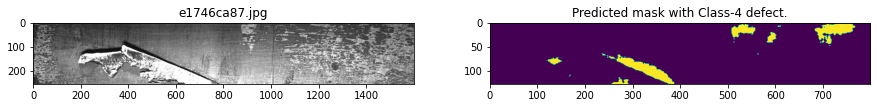

------------------------------------------------------------------------------------------------------------------------------------------------------


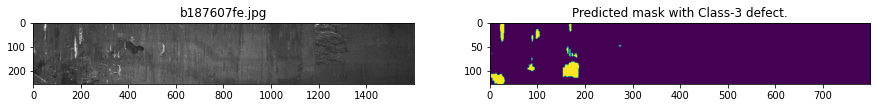

------------------------------------------------------------------------------------------------------------------------------------------------------


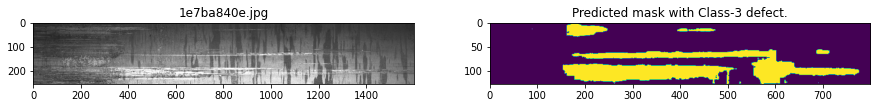

------------------------------------------------------------------------------------------------------------------------------------------------------


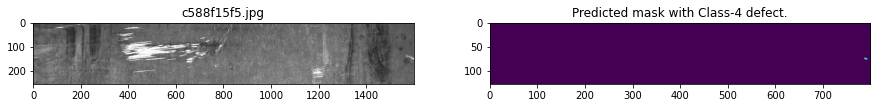

------------------------------------------------------------------------------------------------------------------------------------------------------


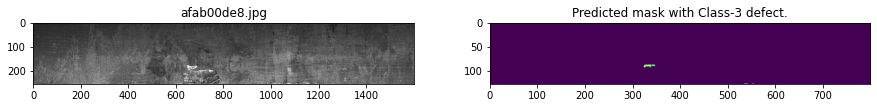

------------------------------------------------------------------------------------------------------------------------------------------------------


In [0]:
visualize_defects_test(output_df,5)

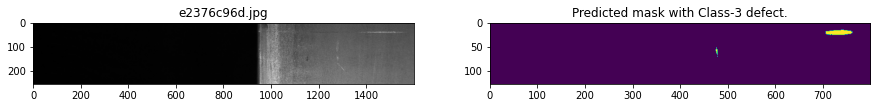

------------------------------------------------------------------------------------------------------------------------------------------------------


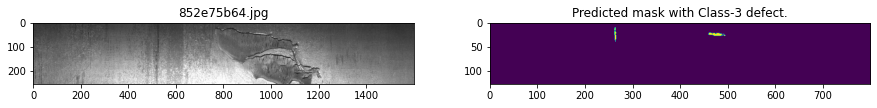

------------------------------------------------------------------------------------------------------------------------------------------------------


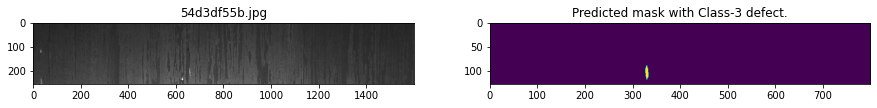

------------------------------------------------------------------------------------------------------------------------------------------------------


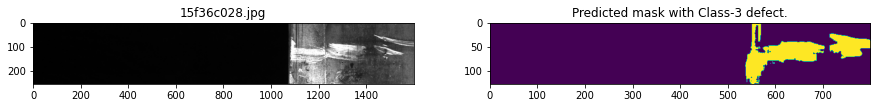

------------------------------------------------------------------------------------------------------------------------------------------------------


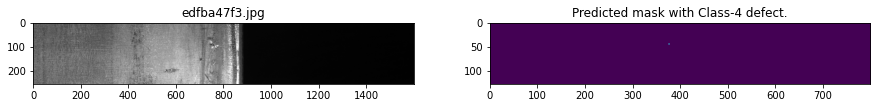

------------------------------------------------------------------------------------------------------------------------------------------------------


In [0]:
visualize_defects_test(output_df,5)

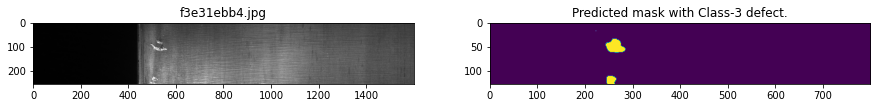

------------------------------------------------------------------------------------------------------------------------------------------------------


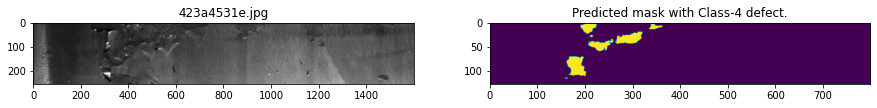

------------------------------------------------------------------------------------------------------------------------------------------------------


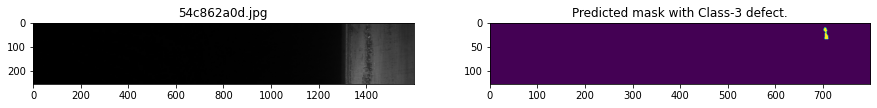

------------------------------------------------------------------------------------------------------------------------------------------------------


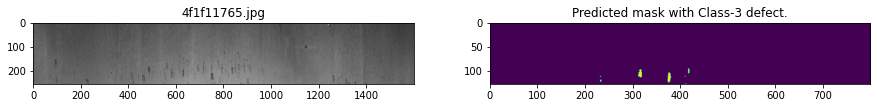

------------------------------------------------------------------------------------------------------------------------------------------------------


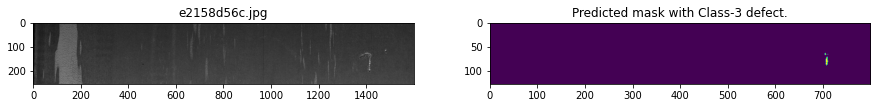

------------------------------------------------------------------------------------------------------------------------------------------------------


In [0]:
visualize_defects_test(output_df,5)

# 2.0 Segmentation Net(Segnet)

![pic](https://drive.google.com/uc?id=1xTvYLmPfRvNzQ9LdGZR3YLAfjI5pZgwk)

**References-**
- https://github.com/imlab-uiip/keras-segnet
- https://arxiv.org/pdf/1505.04366.pdf

In [0]:
def two_conv2d_blocks(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function containing 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

In [0]:
def single_conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function containing 1 convolutional layer with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

In [0]:
def get_segnet(input_img, n_filters, dropout, batchnorm):
    
    """Function to define the Segnet architecture"""
    
    # Encoder Path
    c1 = two_conv2d_blocks(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = two_conv2d_blocks(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = two_conv2d_blocks(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    c3_1 = single_conv2d_block(c3, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3_1)
    p3 = Dropout(dropout)(p3)
    
    c4 = two_conv2d_blocks(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    c4_1= single_conv2d_block(c4, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4_1)
    p4 = Dropout(dropout)(p4)
    
    c5 = two_conv2d_blocks(p4, n_filters = n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    c5_1= single_conv2d_block(c5, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p5 = MaxPooling2D((2, 2))(c5_1)
    p5 = Dropout(dropout)(p5)    
    
    # Decoder Path
    u6 = UpSampling2D()(p5)
    c6 = two_conv2d_blocks(u6,n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    c6 = single_conv2d_block(c6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    c6 = Dropout(dropout)(c6)
    
    u7 = UpSampling2D()(c6)
    c7 = two_conv2d_blocks(u7,n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    c7 = single_conv2d_block(c7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    c7 = Dropout(dropout)(c7)
    
    u8 = UpSampling2D()(c7)
    c8 = two_conv2d_blocks(u8,n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    c8 = single_conv2d_block(c8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    c8 = Dropout(dropout)(c8)
    
    u9 = UpSampling2D()(c8)
    c9 = single_conv2d_block(u9,n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    c9 = single_conv2d_block(c9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    c9 = Dropout(dropout)(c9)
    
    u10 = UpSampling2D()(c9)
    c10 = single_conv2d_block(u10,n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    c10 = Dropout(dropout)(c10)
    
    outputs = Conv2D(4, (1, 1), activation='sigmoid')(c10)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [0]:
input_img = Input((128,800,3),name='img')
model = get_segnet(input_img, n_filters=16, dropout=0.5, batchnorm=True)
model.compile(optimizer=Adam(), loss=bce_dice_loss, metrics=[dice_coef])
model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             (None, 128, 800, 3)       0         
_________________________________________________________________
conv2d_79 (Conv2D)           (None, 128, 800, 16)      448       
_________________________________________________________________
batch_normalization_76 (Batc (None, 128, 800, 16)      64        
_________________________________________________________________
activation_76 (Activation)   (None, 128, 800, 16)      0         
_________________________________________________________________
conv2d_80 (Conv2D)           (None, 128, 800, 16)      2320      
_________________________________________________________________
batch_normalization_77 (Batc (None, 128, 800, 16)      64        
_________________________________________________________________
activation_77 (Activation)   (None, 128, 800, 16)      0   

## 2.1 Checkpointing the model and creating the callback list

In [0]:
tbc=TensorBoardColab()
mc = ModelCheckpoint('best_model_segnet.h5', monitor='val_dice_coef', verbose=1, save_best_only=True, mode='max')
callbacks_list = [mc, TensorBoardColabCallback(tbc)]

Wait for 8 seconds...
TensorBoard link:
http://513dcfc3.ngrok.io


## 2.2 Fitting the train data and validation

In [0]:
train_batches = Train_DataGenerator(train_data,shuffle=True)
valid_batches = Val_DataGenerator(cv_data)
history = model.fit_generator(train_batches, validation_data = valid_batches, epochs = 30, verbose=1,
                              class_weight=class_wts, callbacks = callbacks_list)





Epoch 1/30
667/667 [==============================] - 263s 395ms/step - loss: 1.0959 - dice_coef: 0.0619 - val_loss: 1.1521 - val_dice_coef: 0.1376

Epoch 00001: val_dice_coef improved from -inf to 0.13762, saving model to best_model.h5

Epoch 2/30
667/667 [==============================] - 236s 353ms/step - loss: 0.7808 - dice_coef: 0.2758 - val_loss: 0.7062 - val_dice_coef: 0.3639

Epoch 00002: val_dice_coef improved from 0.13762 to 0.36390, saving model to best_model.h5
Epoch 3/30
667/667 [==============================] - 238s 357ms/step - loss: 0.6896 - dice_coef: 0.3686 - val_loss: 0.6413 - val_dice_coef: 0.4156

Epoch 00003: val_dice_coef improved from 0.36390 to 0.41558, saving model to best_model.h5
Epoch 4/30
667/667 [==============================] - 237s 356ms/step - loss: 0.6508 - dice_coef: 0.4057 - val_loss: 0.6436 - val_dice_coef: 0.4211

Epoch 00004: val_dice_coef improved from 0.41558 to 0.42105, saving model to best_model.h5
Epoch 5/30
667/667 [==================

### Continued for another 20 epochs to see if the score improves

In [0]:
train_batches = Train_DataGenerator(train_data,shuffle=True)
valid_batches = Val_DataGenerator(cv_data)
history = model.fit_generator(train_batches, validation_data = valid_batches, epochs = 20, verbose=1,
                              class_weight=class_wts, callbacks = callbacks_list)

Epoch 1/20
667/667 [==============================] - 246s 369ms/step - loss: 0.4945 - dice_coef: 0.5485 - val_loss: 0.5506 - val_dice_coef: 0.5031

Epoch 00001: val_dice_coef improved from -inf to 0.50306, saving model to best_model.h5
Epoch 2/20
667/667 [==============================] - 240s 359ms/step - loss: 0.4942 - dice_coef: 0.5486 - val_loss: 0.5610 - val_dice_coef: 0.4920

Epoch 00002: val_dice_coef did not improve from 0.50306
Epoch 3/20
667/667 [==============================] - 240s 360ms/step - loss: 0.4987 - dice_coef: 0.5444 - val_loss: 0.6268 - val_dice_coef: 0.4365

Epoch 00003: val_dice_coef did not improve from 0.50306
Epoch 4/20
667/667 [==============================] - 240s 360ms/step - loss: 0.4955 - dice_coef: 0.5482 - val_loss: 0.5665 - val_dice_coef: 0.4886

Epoch 00004: val_dice_coef did not improve from 0.50306
Epoch 5/20
667/667 [==============================] - 240s 361ms/step - loss: 0.4876 - dice_coef: 0.5549 - val_loss: 0.5313 - val_dice_coef: 0.5168


## 2.3 Plots on training & validation results

### Loss function & metric plots

**Please refer to Training Plots in utility functions section.**

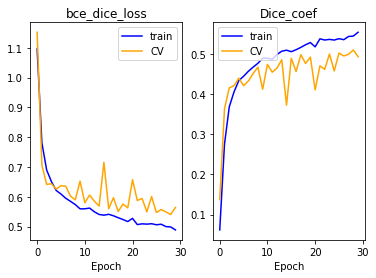

In [0]:
#first 30 epochs
plot(history)

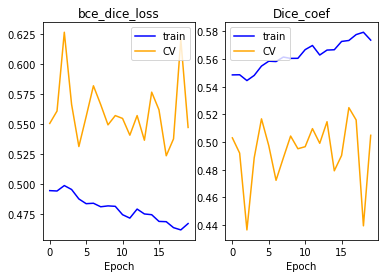

In [0]:
#next 20 epochs
plot(history)

### Tensorboard images

![alt text](https://drive.google.com/uc?id=1VtsEq2k8kSqAx3VNdyBtCzpUn8k_Y7vh)

![alt text](https://drive.google.com/uc?id=1GF0TiUCJCKp8LjdFzkkYhJkZeKwjeAG6)

![alt text](https://drive.google.com/uc?id=1itGRDqClUu3g1lNovet0ePpbBlc6-KC3)

## 2.4 Model Testing

### Loading the best model for evaluation

** Considering the best model which was trained on 30 epochs as the model in the next 20 epochs experienced the problem of overfitting.**

In [0]:
from keras.models import load_model
dependencies = {'bce_dice_loss':bce_dice_loss,'dice_coef':dice_coef,}
model_best = load_model('/content/best_model_segnet.h5',custom_objects=dependencies)

### Evaluating on validation images

In [0]:
evals= model_best.evaluate(valid_batches,verbose=1)

117/117 [==============================] - 31s 261ms/step


In [0]:
print('Validation set evaluation score:')
print('bce_dice loss:',evals[0])
print('dice_coeff:',evals[1])

Validation set evaluation score:
bce_dice loss: 0.5403748965925641
dice_coeff: 0.5100375587515171


## 2.5 Defects visualization

**Please refer to the "visualize_defects" function in Utility functions section.**

### Training set

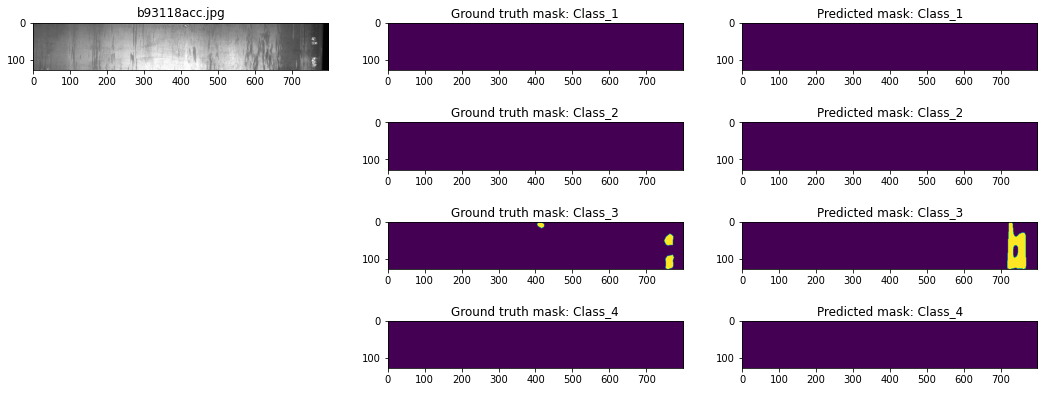

------------------------------------------------------------------------------------------------------------------------------------------------------


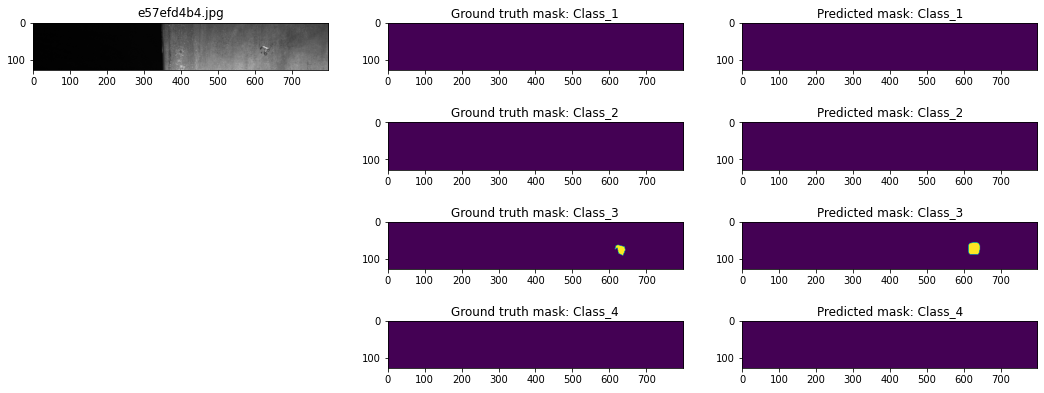

------------------------------------------------------------------------------------------------------------------------------------------------------


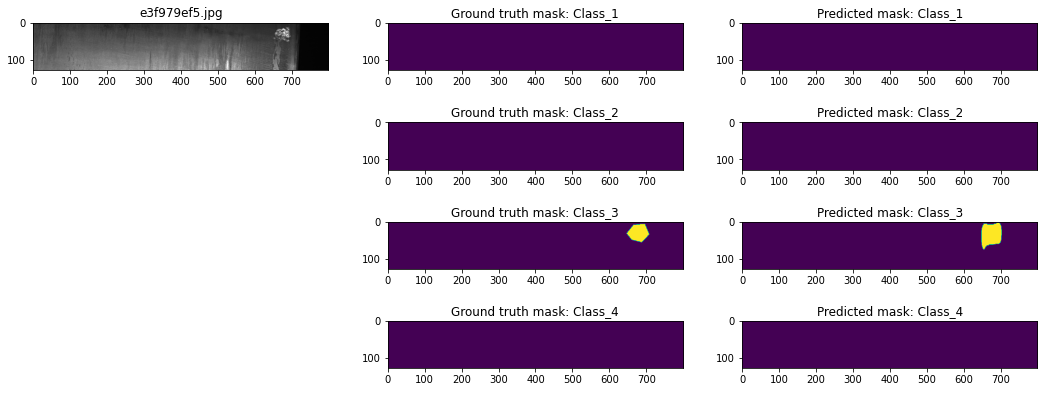

------------------------------------------------------------------------------------------------------------------------------------------------------


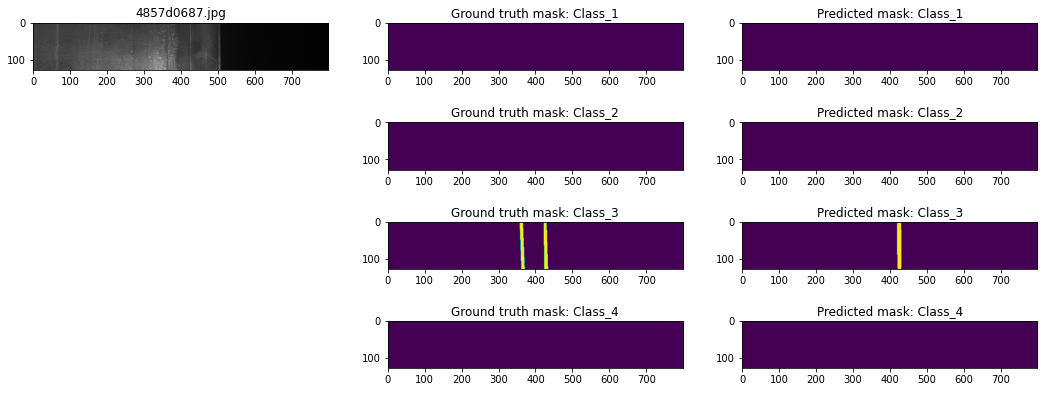

------------------------------------------------------------------------------------------------------------------------------------------------------


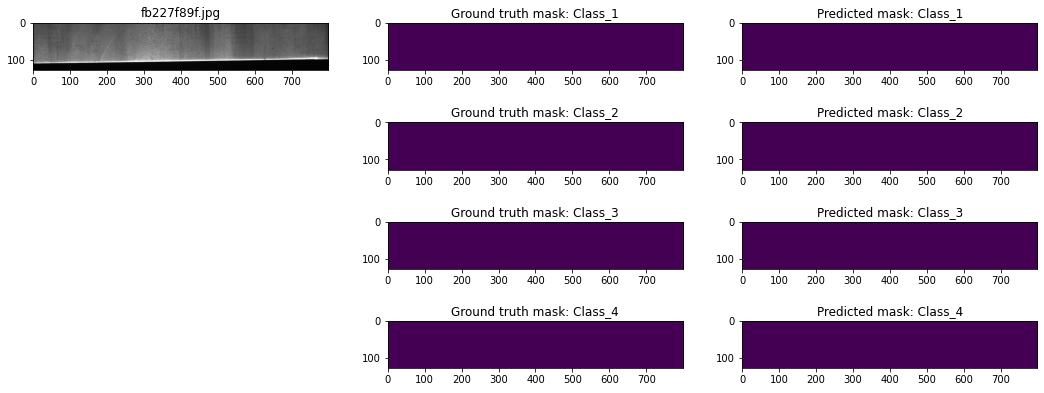

------------------------------------------------------------------------------------------------------------------------------------------------------


In [0]:
visualize_defects(train_data,model_best)

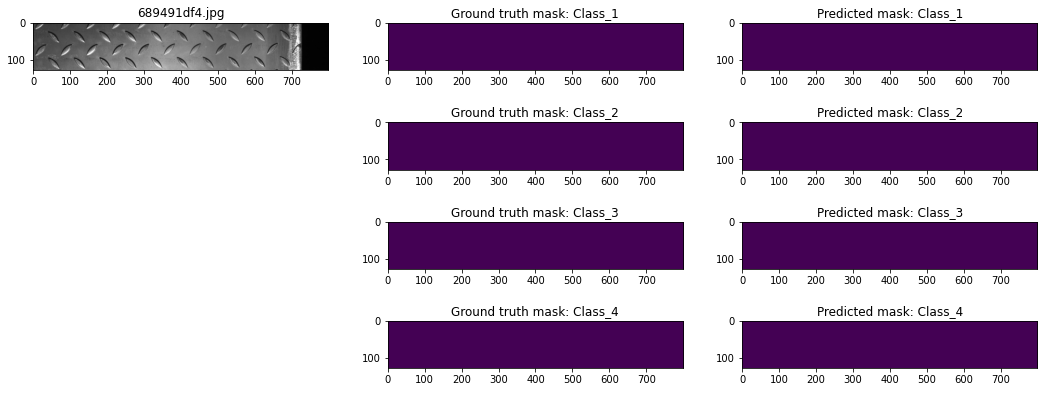

------------------------------------------------------------------------------------------------------------------------------------------------------


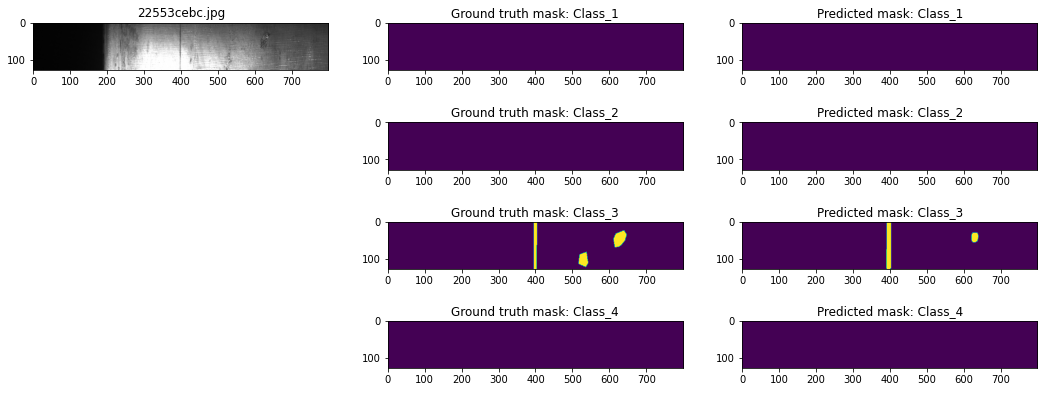

------------------------------------------------------------------------------------------------------------------------------------------------------


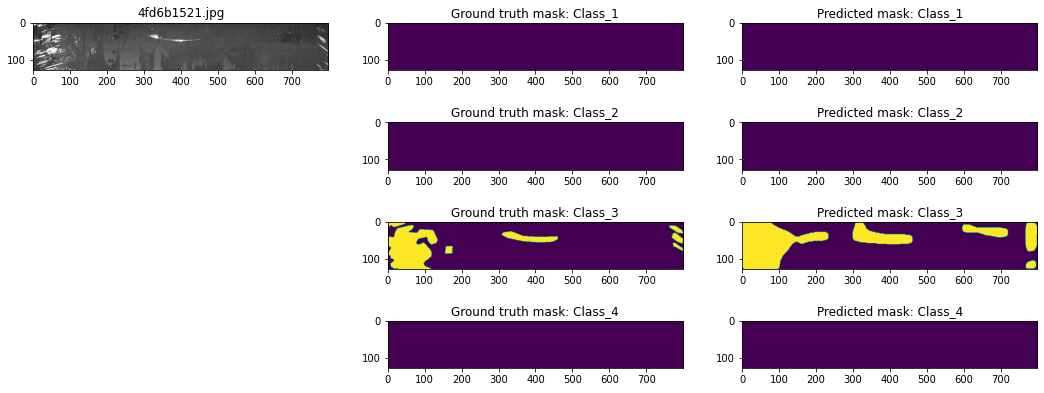

------------------------------------------------------------------------------------------------------------------------------------------------------


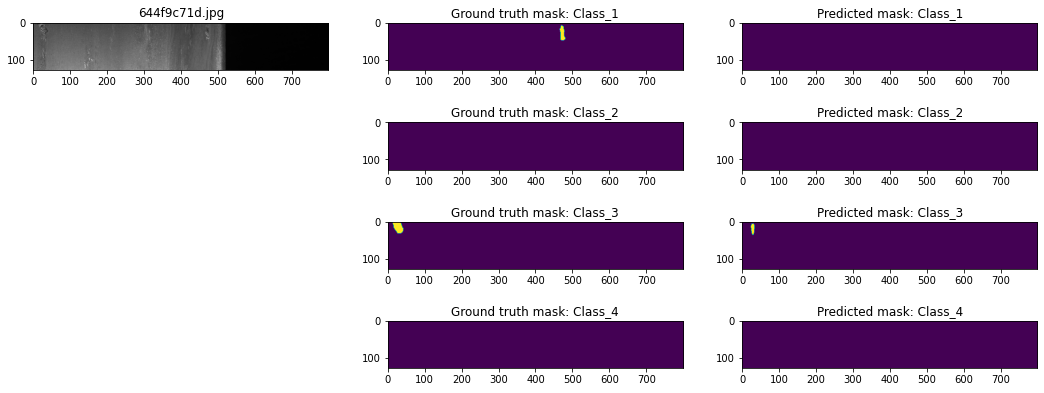

------------------------------------------------------------------------------------------------------------------------------------------------------


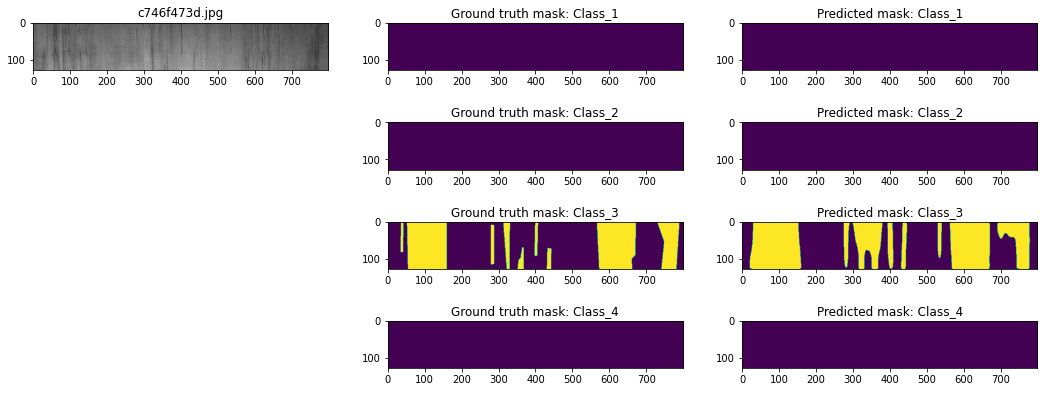

------------------------------------------------------------------------------------------------------------------------------------------------------


In [0]:
visualize_defects(train_data,model_best)

### Validation set

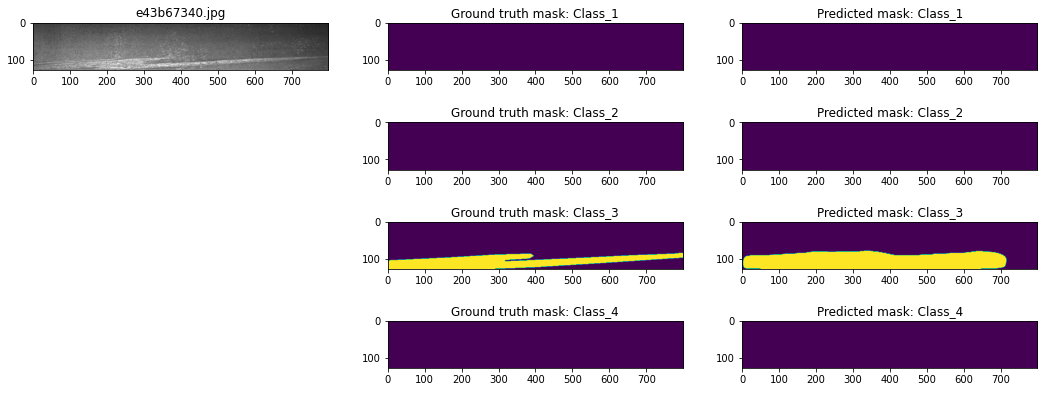

------------------------------------------------------------------------------------------------------------------------------------------------------


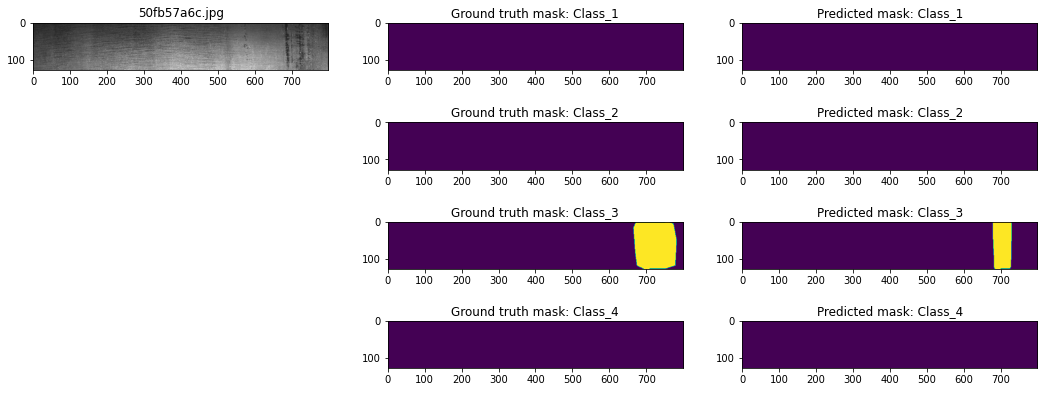

------------------------------------------------------------------------------------------------------------------------------------------------------


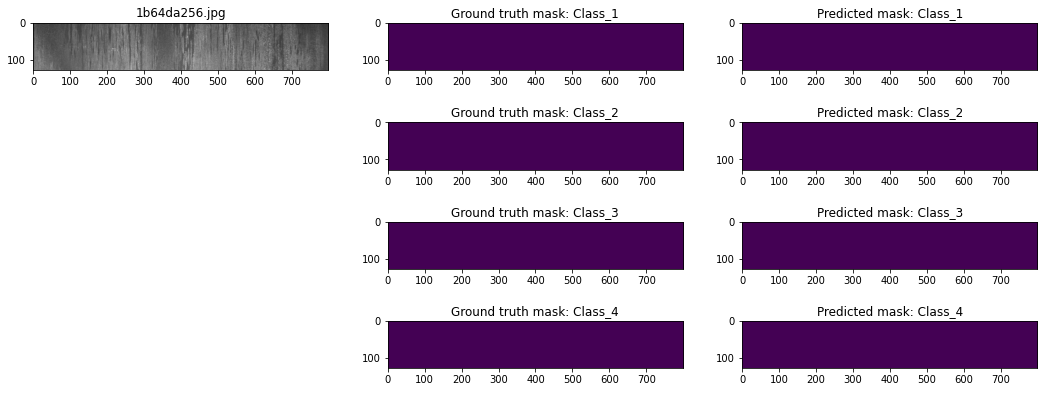

------------------------------------------------------------------------------------------------------------------------------------------------------


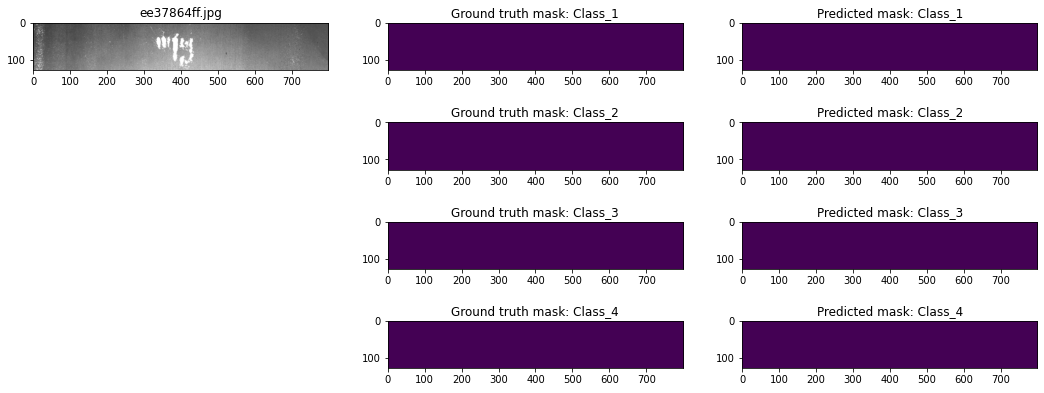

------------------------------------------------------------------------------------------------------------------------------------------------------


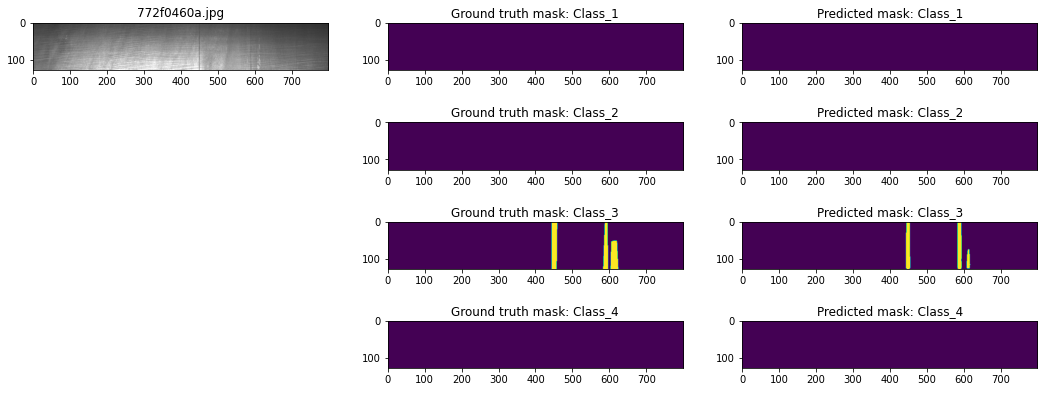

------------------------------------------------------------------------------------------------------------------------------------------------------


In [0]:
visualize_defects(cv_data,model_best)

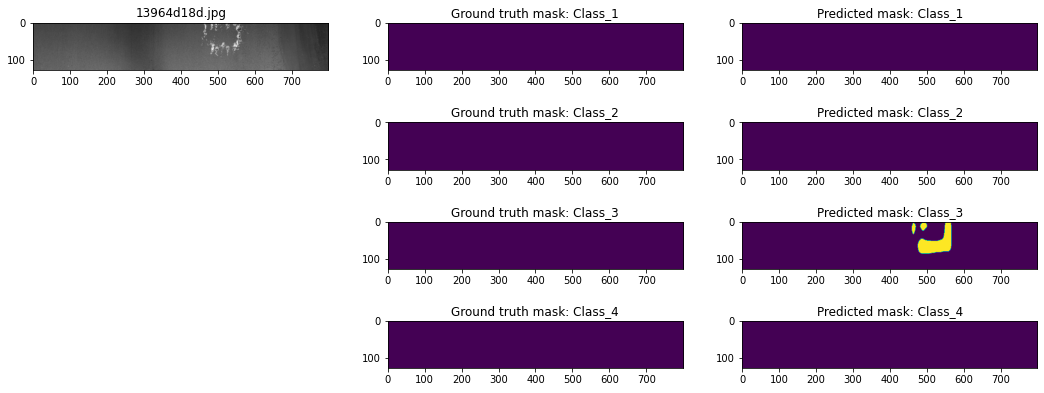

------------------------------------------------------------------------------------------------------------------------------------------------------


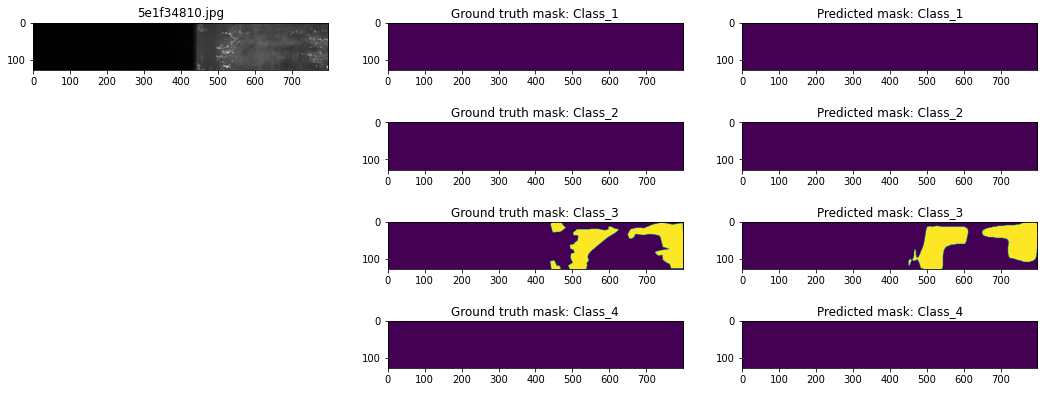

------------------------------------------------------------------------------------------------------------------------------------------------------


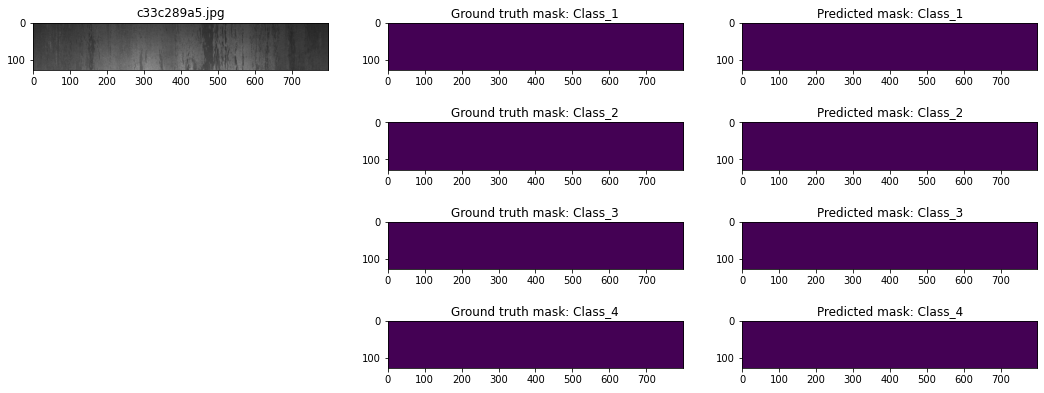

------------------------------------------------------------------------------------------------------------------------------------------------------


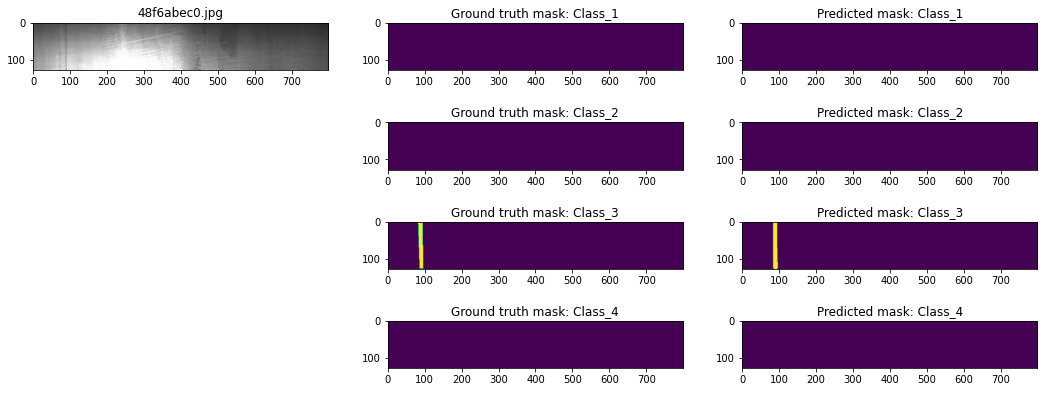

------------------------------------------------------------------------------------------------------------------------------------------------------


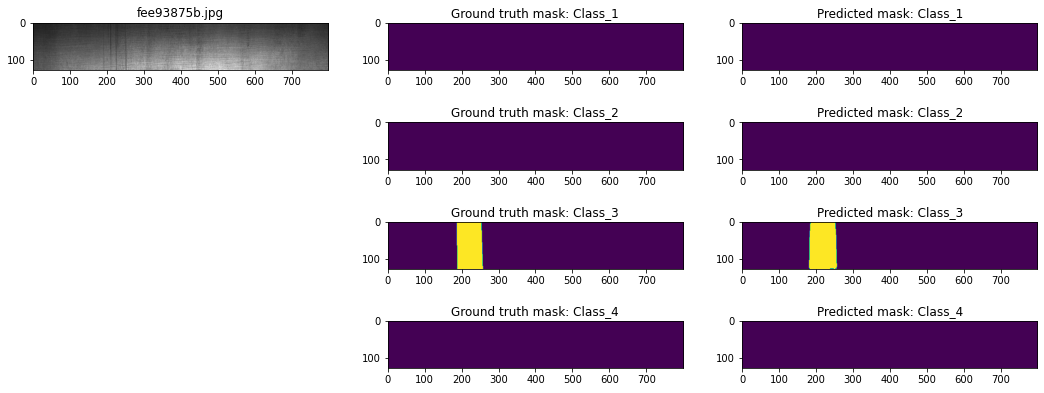

------------------------------------------------------------------------------------------------------------------------------------------------------


In [0]:
visualize_defects(cv_data,model_best)

## 2.6 Predicting defects on raw test images

### Redefining the segnet architecture for original image size of 256x1600

In [0]:
input_img = Input((256,1600,3),name='img')
model1 = get_segnet(input_img, n_filters=16, dropout=0.5, batchnorm=True)
model1.compile(optimizer=Adam(), loss=bce_dice_loss, metrics=[dice_coef])
model1.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             (None, 256, 1600, 3)      0         
_________________________________________________________________
conv2d_105 (Conv2D)          (None, 256, 1600, 16)     448       
_________________________________________________________________
batch_normalization_101 (Bat (None, 256, 1600, 16)     64        
_________________________________________________________________
activation_101 (Activation)  (None, 256, 1600, 16)     0         
_________________________________________________________________
conv2d_106 (Conv2D)          (None, 256, 1600, 16)     2320      
_________________________________________________________________
batch_normalization_102 (Bat (None, 256, 1600, 16)     64        
_________________________________________________________________
activation_102 (Activation)  (None, 256, 1600, 16)     0   

In [0]:
model1.set_weights(model_best.get_weights())

### Predicting on full 256x1600 raw test images

In [0]:
# Predicting on test images
from tqdm import tqdm
import cv2
data_path = '/content/' + 'test_images/'
files = list(os.listdir(data_path))
rle_lst = [] #list to store defect in run length encoding format
img_classId= [] #list to store Image ID + classId

for f in tqdm(files):
    X = np.empty((1,256,1600,3),dtype=np.float32)
    img = cv2.imread(data_path + f)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    X[0,] = img
    mask = model1.predict(X)
    rle_m = np.empty((256,1600),dtype=np.uint8)
    for i in range(4):
        rle_m = mask[0,:,:,i].round().astype(int)
        rle = mask2rle(rle_m)
        rle_lst.append(rle)
        img_classId.append(f+'_'+str(i+1))

100%|██████████| 5506/5506 [05:19<00:00, 17.21it/s]


In [0]:
output = {'ImageId_ClassId':img_classId, 'EncodedPixels' : rle_lst}
output_df = pd.DataFrame(output)
output_df.to_csv('submission_segnet_256x1600.csv', index=False)

**With this submission, I got a private dice coefficient score of 0.83437 & a public score of 0.84740.**

## 2.7 Visualizing defects of raw test images(256x1600)

**Please refer to the "visualize_defects_test" function in Utility functions section.**

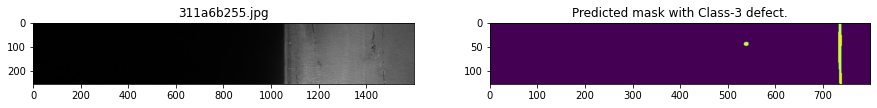

------------------------------------------------------------------------------------------------------------------------------------------------------


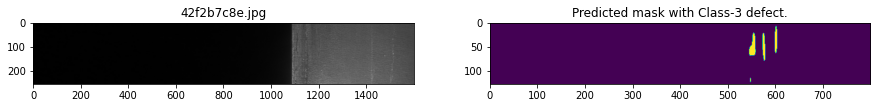

------------------------------------------------------------------------------------------------------------------------------------------------------


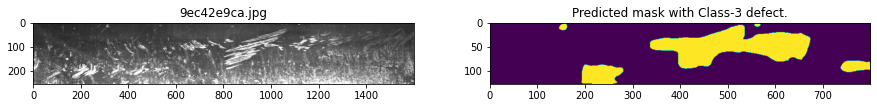

------------------------------------------------------------------------------------------------------------------------------------------------------


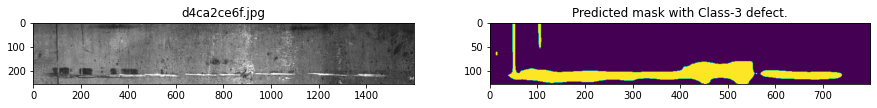

------------------------------------------------------------------------------------------------------------------------------------------------------


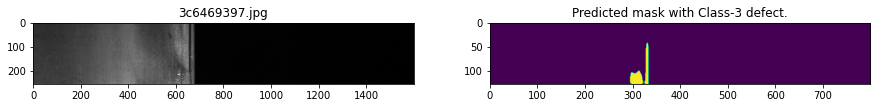

------------------------------------------------------------------------------------------------------------------------------------------------------


In [0]:
visualize_defects(output_df,5)

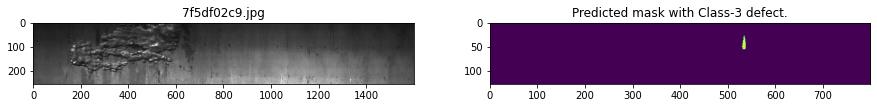

------------------------------------------------------------------------------------------------------------------------------------------------------


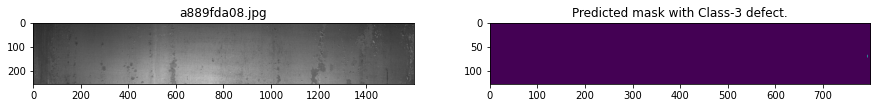

------------------------------------------------------------------------------------------------------------------------------------------------------


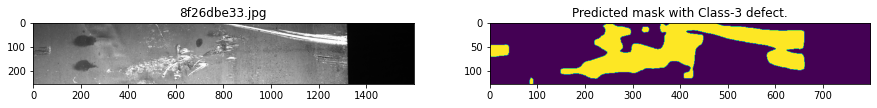

------------------------------------------------------------------------------------------------------------------------------------------------------


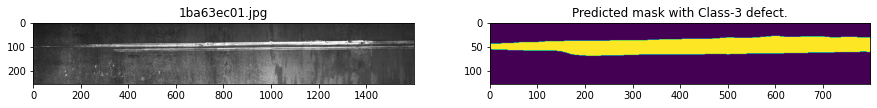

------------------------------------------------------------------------------------------------------------------------------------------------------


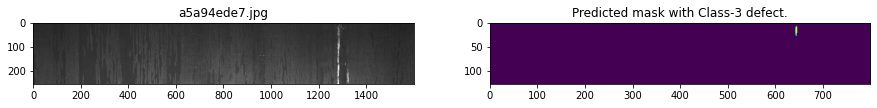

------------------------------------------------------------------------------------------------------------------------------------------------------


In [0]:
visualize_defects(output_df,5)

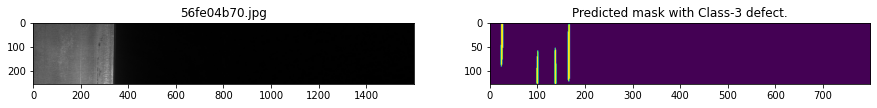

------------------------------------------------------------------------------------------------------------------------------------------------------


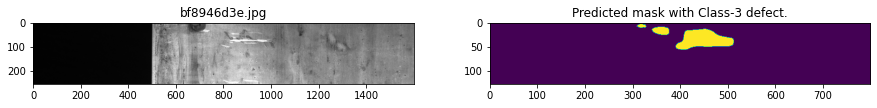

------------------------------------------------------------------------------------------------------------------------------------------------------


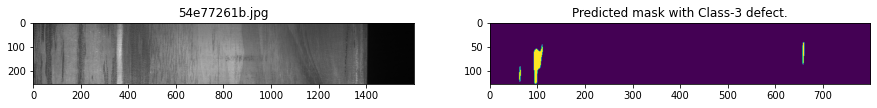

------------------------------------------------------------------------------------------------------------------------------------------------------


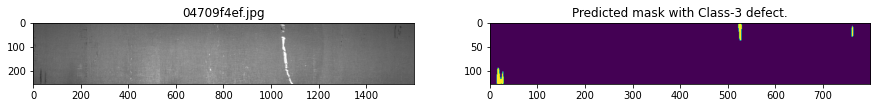

------------------------------------------------------------------------------------------------------------------------------------------------------


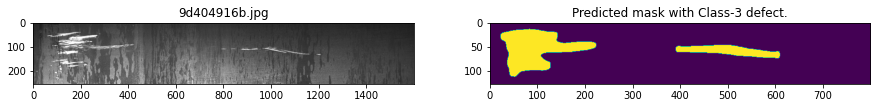

------------------------------------------------------------------------------------------------------------------------------------------------------


In [0]:
visualize_defects(output_df,5)

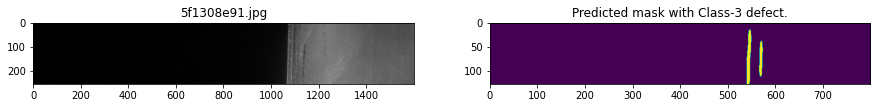

------------------------------------------------------------------------------------------------------------------------------------------------------


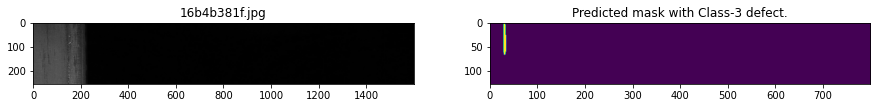

------------------------------------------------------------------------------------------------------------------------------------------------------


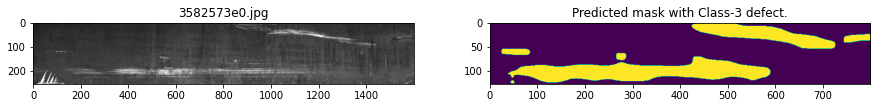

------------------------------------------------------------------------------------------------------------------------------------------------------


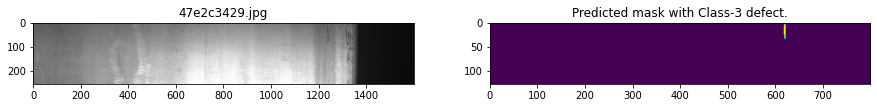

------------------------------------------------------------------------------------------------------------------------------------------------------


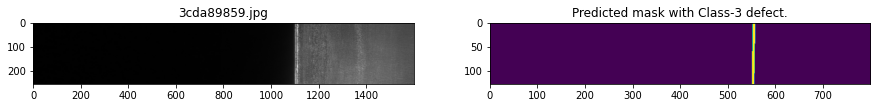

------------------------------------------------------------------------------------------------------------------------------------------------------


In [0]:
visualize_defects(output_df,5)

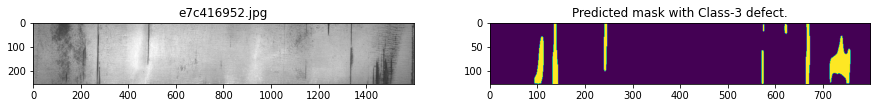

------------------------------------------------------------------------------------------------------------------------------------------------------


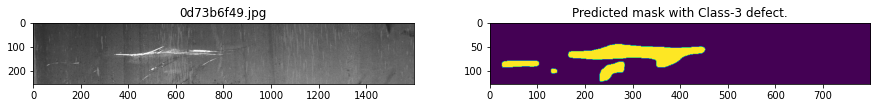

------------------------------------------------------------------------------------------------------------------------------------------------------


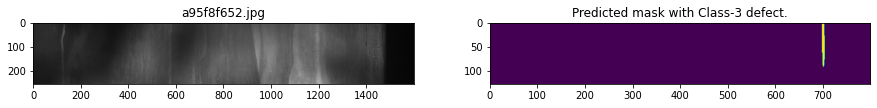

------------------------------------------------------------------------------------------------------------------------------------------------------


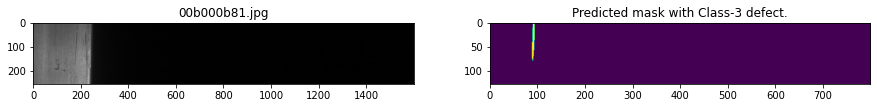

------------------------------------------------------------------------------------------------------------------------------------------------------


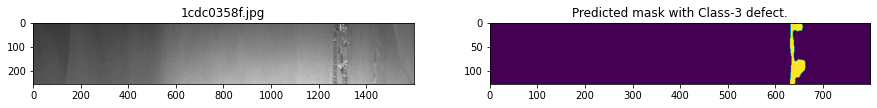

------------------------------------------------------------------------------------------------------------------------------------------------------


In [0]:
visualize_defects(output_df,5)

# 3.0 Implementing FCN-8 architecture

![alt text](https://drive.google.com/uc?id=1g7I0P5spyA5P2T7oucrEECf1Ie3VgL-b)

![alt text](https://drive.google.com/uc?id=1ywE_08nks3H7CAVEZHLCXUr4VeHuQKSO)

**References-**
- https://github.com/seth814/Semantic-Shapes
- https://fairyonice.github.io/Learn-about-Fully-Convolutional-Networks-for-semantic-segmentation.html
- https://www.youtube.com/watch?v=-3ylPH3BCWY

In [0]:
def fcn_8(img_shape, base, dropout,n_classes):
    i = Input(shape=img_shape)
    b= base
    
    ## Block 1
    x = Conv2D(2**b, (3, 3), activation='relu', kernel_initializer = 'he_normal', padding='same', name='block1_conv1')(i)
    x = BatchNormalization()(x)
    x = Conv2D(2**b, (3, 3), activation='relu', kernel_initializer = 'he_normal', padding='same', name='block1_conv2')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)
    x = Dropout(dropout)(x)
    
    # Block 2
    x = Conv2D(2**(b+1), (3, 3), activation='relu', kernel_initializer = 'he_normal', padding='same', name='block2_conv1')(x)
    x = BatchNormalization()(x)
    x = Conv2D(2**(b+1), (3, 3), activation='relu', kernel_initializer = 'he_normal', padding='same', name='block2_conv2')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)
    x = Dropout(dropout)(x)
    
    # Block 3
    x = Conv2D(2**(b+2), (3, 3), activation='relu', kernel_initializer = 'he_normal', padding='same', name='block3_conv1')(x)
    x = BatchNormalization()(x)
    x = Conv2D(2**(b+2), (3, 3), activation='relu', kernel_initializer = 'he_normal', padding='same', name='block3_conv2')(x)
    x = BatchNormalization()(x)
    x = Conv2D(2**(b+2), (3, 3), activation='relu', kernel_initializer = 'he_normal', padding='same', name='block3_conv3')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)
    x = Dropout(dropout)(x)
    pool3 = x
    
    # Block 4
    x = Conv2D(2**(b+3), (3, 3), activation='relu', kernel_initializer = 'he_normal', padding='same', name='block4_conv1')(x)
    x = BatchNormalization()(x)
    x = Conv2D(2**(b+3), (3, 3), activation='relu', kernel_initializer = 'he_normal', padding='same', name='block4_conv2')(x)
    x = BatchNormalization()(x)
    x = Conv2D(2**(b+3), (3, 3), activation='relu', kernel_initializer = 'he_normal', padding='same', name='block4_conv3')(x)
    x = BatchNormalization()(x)
    pool4 = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)
    pool4 = Dropout(dropout)(pool4)
    
    # Block 5
    x = Conv2D(2**(b+3), (3, 3), activation='relu', kernel_initializer = 'he_normal', padding='same', name='block5_conv1')(pool4)
    x = BatchNormalization()(x)
    x = Conv2D(2**(b+3), (3, 3), activation='relu', kernel_initializer = 'he_normal', padding='same', name='block5_conv2')(x)
    x = BatchNormalization()(x)
    x = Conv2D(2**(b+3), (3, 3), activation='relu', kernel_initializer = 'he_normal', padding='same', name='block5_conv3')(x)
    x = BatchNormalization()(x)
    pool5 = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)
    pool5 = Dropout(dropout)(pool5)
    
    conv6 = Conv2D(2**(b+3)*8 , (7, 7) , activation='relu', kernel_initializer = 'he_normal' , padding='same', name="conv6")(pool5)
    conv6 = BatchNormalization()(conv6)
    conv6 = Dropout(0.5)(conv6)
    conv7 = Conv2D(2**(b+3)*8 , (1, 1) , activation='relu', kernel_initializer = 'he_normal' , padding='same', name="conv7")(conv6)
    conv7 = BatchNormalization()(conv7)
    conv7 = Dropout(0.5)(conv7)
    
    pool4_n = Conv2D(n_classes, (1, 1), activation='relu', kernel_initializer = 'he_normal', padding='same')(pool4)
    u2 = Conv2DTranspose(n_classes, kernel_size=(2, 2), strides=(2, 2), padding='same')(conv7)
    u2_skip = Add()([pool4_n, u2])
    
    pool3_n = Conv2D(n_classes, (1, 1), activation='relu', padding='same')(pool3)
    u4 = Conv2DTranspose(n_classes, kernel_size=(2, 2), strides=(2, 2), padding='same')(u2_skip)
    u4_skip = Add()([pool3_n, u4])
    
    output = Conv2DTranspose(n_classes, kernel_size=(8, 8), strides=(8, 8), padding='same',activation='sigmoid')(u4_skip)
    
    model = Model(inputs=[i], outputs=[output])
    
    return model

In [0]:
#https://keras.io/models/model/#fit_generator
model= fcn_8(img_shape= (128,800,3), base= 4, dropout= 0.3, n_classes= 4)
model.compile(optimizer=Adam(), loss=bce_dice_loss, metrics=[dice_coef])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 128, 800, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 128, 800, 16) 448         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_16 (BatchNo (None, 128, 800, 16) 64          block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 128, 800, 16) 2320        batch_normalization_16[0][0]     
____________________________________________________________________________________________

## 3.1 Checkpointing the model and creating the callback list

In [0]:
tbc=TensorBoardColab()
mc = ModelCheckpoint('best_model_fcn8.h5', monitor='val_dice_coef', verbose=1, save_best_only=True, mode='max')
callbacks_list = [mc, TensorBoardColabCallback(tbc)]

Wait for 8 seconds...
TensorBoard link:
https://358ac569.ngrok.io


## 3.2 Fitting the train data and validation

In [0]:
train_batches = Train_DataGenerator(train_data,shuffle=True)
valid_batches = Val_DataGenerator(cv_data)
history = model.fit_generator(train_batches, validation_data = valid_batches, epochs = 30, verbose=1, 
                              class_weight=class_wts, callbacks = callbacks_list)

ERROR! Session/line number was not unique in database. History logging moved to new session 60




Epoch 1/30
667/667 [==============================] - 262s 392ms/step - loss: 0.8073 - dice_coef: 0.2814 - val_loss: 0.7385 - val_dice_coef: 0.3199

Epoch 00001: val_dice_coef improved from -inf to 0.31990, saving model to best_model.h5

Epoch 2/30
667/667 [==============================] - 236s 354ms/step - loss: 0.6018 - dice_coef: 0.4443 - val_loss: 0.7356 - val_dice_coef: 0.3235

Epoch 00002: val_dice_coef improved from 0.31990 to 0.32351, saving model to best_model.h5
Epoch 3/30
667/667 [==============================] - 238s 357ms/step - loss: 0.5655 - dice_coef: 0.4768 - val_loss: 0.6561 - val_dice_coef: 0.3929

Epoch 00003: val_dice_coef improved from 0.32351 to 0.39290, saving model to best_model.h5
Epoch 4/30
667/667 [==============================] - 239s 358ms/step - loss: 0.5419 - dice_coef: 0.4991 - val_loss: 0.5570 - val_dice_coef: 0.4868

Epoch 00004: val_dice_coef improve

In [0]:
#round 2 for 20 epochs
model= model_best
train_batches = Train_DataGenerator(train_data,shuffle=True)
valid_batches = Val_DataGenerator(cv_data)
class_wts= [1.98,7.18,0.34,2.21]
history = model.fit_generator(train_batches, validation_data = valid_batches, epochs = 20, verbose=1,
                              class_weight=class_wts, callbacks = callbacks_list)



Epoch 1/20
667/667 [==============================] - 260s 389ms/step - loss: 0.5078 - dice_coef: 0.5295 - val_loss: 0.5507 - val_dice_coef: 0.5024

Epoch 00001: val_dice_coef improved from -inf to 0.50236, saving model to best_model.h5

Epoch 2/20
667/667 [==============================] - 244s 366ms/step - loss: 0.5027 - dice_coef: 0.5344 - val_loss: 0.5386 - val_dice_coef: 0.5093

Epoch 00002: val_dice_coef improved from 0.50236 to 0.50929, saving model to best_model.h5
Epoch 3/20
667/667 [==============================] - 251s 376ms/step - loss: 0.4952 - dice_coef: 0.5414 - val_loss: 0.5888 - val_dice_coef: 0.4639

Epoch 00003: val_dice_coef did not improve from 0.50929
Epoch 4/20
667/667 [==============================] - 249s 374ms/step - loss: 0.4775 - dice_coef: 0.5588 - val_loss: 0.5142 - val_dice_coef: 0.5323

Epoch 00004: val_dice_coef improved from 0.50929 to 0.53226, saving model to best_model.h5
Epoch 5/20
667/667 [==============================] - 241s 362ms/step - los

## 3.3 Plots on training & validation results

### Loss function & metric plots

**Please refer to Training Plots in utility functions section.**

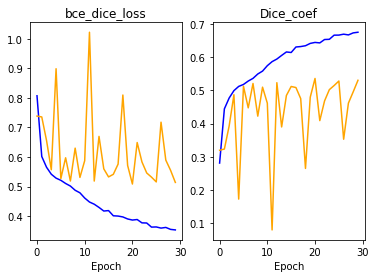

In [0]:
#first 30 epochs
plot(history)

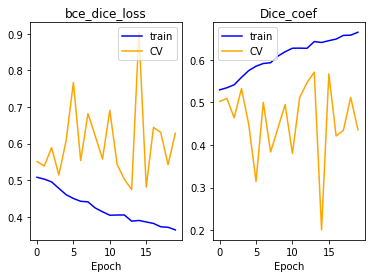

In [0]:
#next 20 epochs
plot(history)

### Tensorboard images

![alt text](https://drive.google.com/uc?id=1o3Hs72Xzl7PdDKKbrqMDCKVDt3uwG7Q-)

![alt text](https://drive.google.com/uc?id=1wKQ-ODvDQ6OjeVKjEFwg1P0Zs89Vo0DK)

![alt text](https://drive.google.com/uc?id=13G4T-Z31nuttI7oGn1D6g5QPuT-lMj2h)

## 3.4 Model Testing

### Loading the best model for evaluation

** Considering the best model which was trained on 30 epochs as the model in the next 20 epochs experienced the problem of overfitting.**

In [0]:
from keras.models import load_model
dependencies = {'bce_dice_loss':bce_dice_loss,'dice_coef':dice_coef,}
model_best = load_model('/content/best_model_fcn8.h5',custom_objects=dependencies)

### Evaluating on validation images

In [0]:
evals1= model_best.evaluate(valid_batches,verbose=1)

117/117 [==============================] - 33s 282ms/step


In [0]:
print('Validation set evaluation score:')
print('bce_dice loss:',evals1[0])
print('dice_coeff:',evals1[1])

Validation set evaluation score:
bce_dice loss: 0.5122087106236026
dice_coeff: 0.531455701447896


## 3.5 Defects visualization

**Please refer to the "visualize_defects" function in Utility functions section.**

### Training set

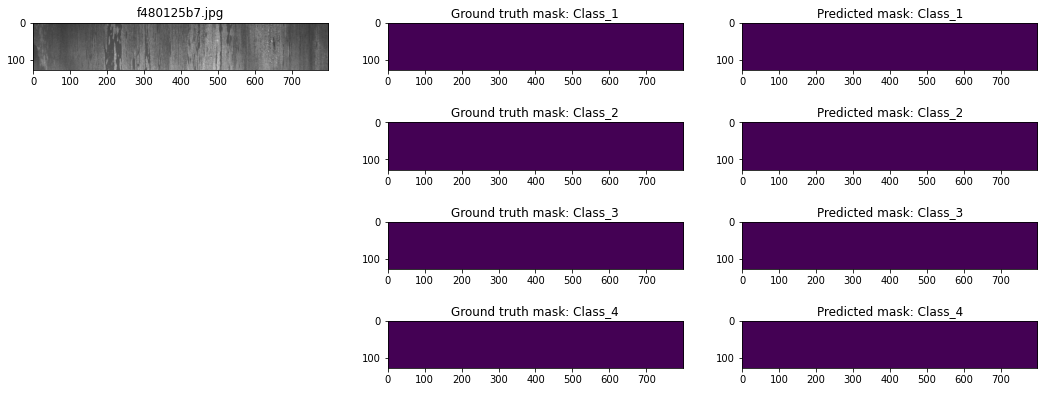

------------------------------------------------------------------------------------------------------------------------------------------------------


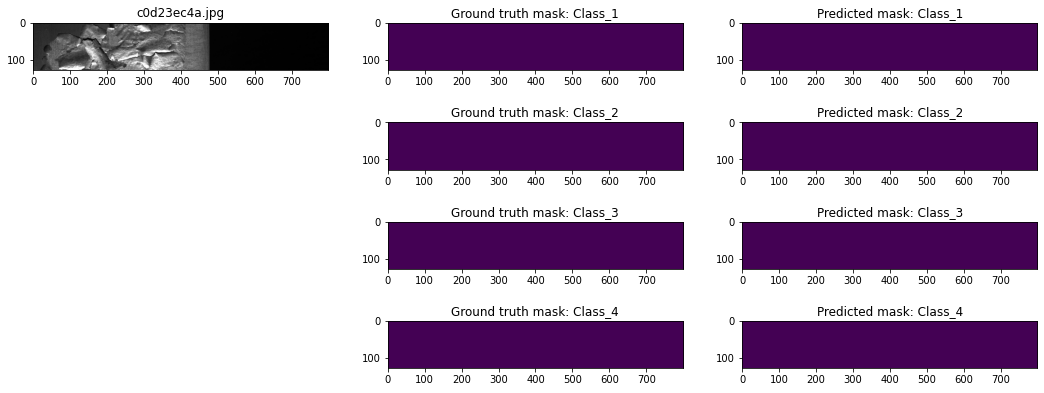

------------------------------------------------------------------------------------------------------------------------------------------------------


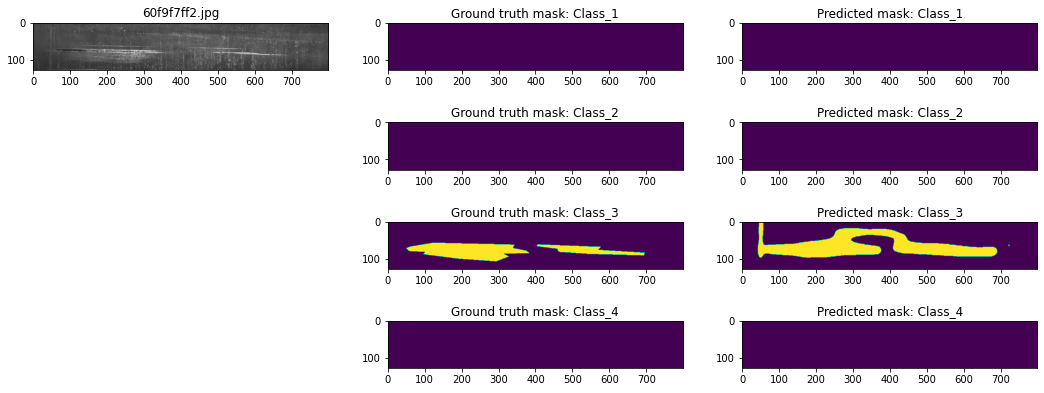

------------------------------------------------------------------------------------------------------------------------------------------------------


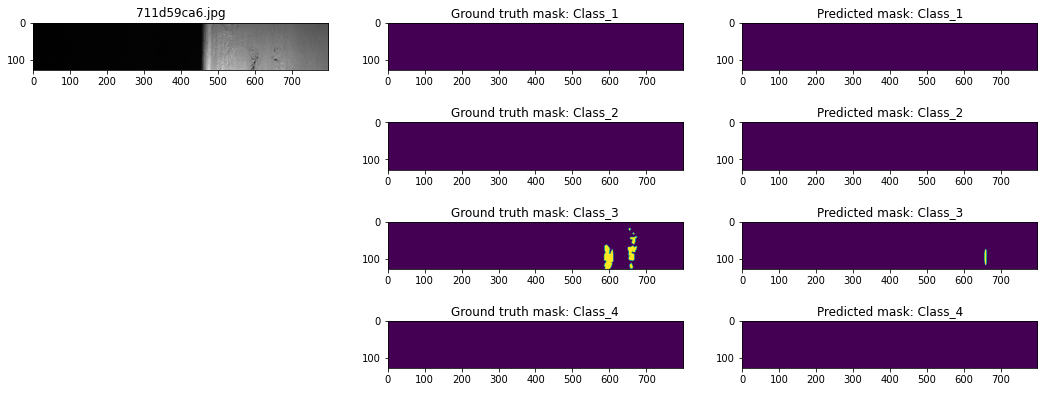

------------------------------------------------------------------------------------------------------------------------------------------------------


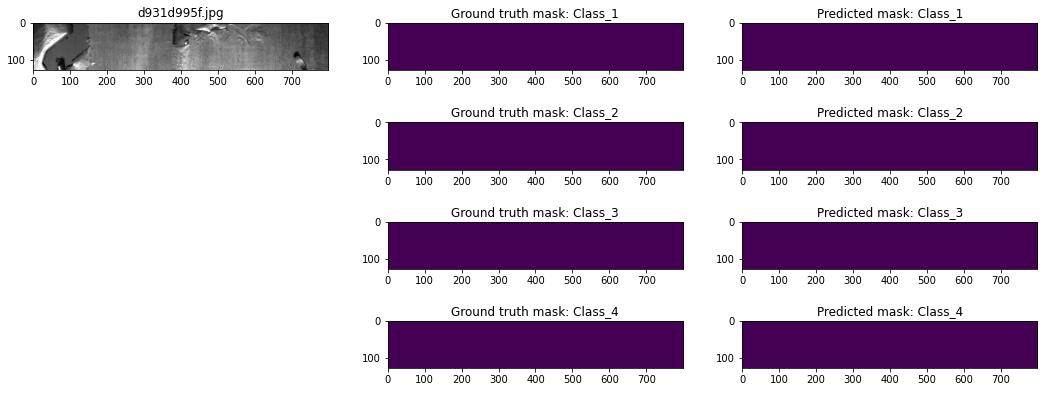

------------------------------------------------------------------------------------------------------------------------------------------------------


In [0]:
visualize_defects(train_data,model_best)

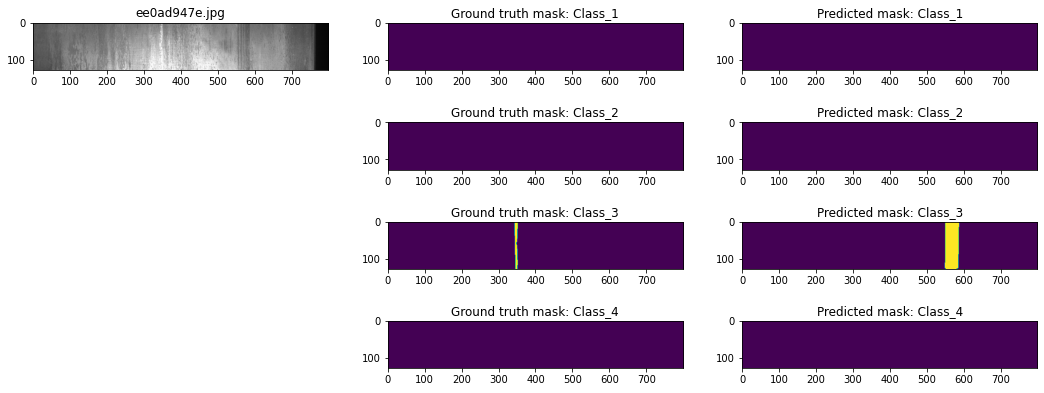

------------------------------------------------------------------------------------------------------------------------------------------------------


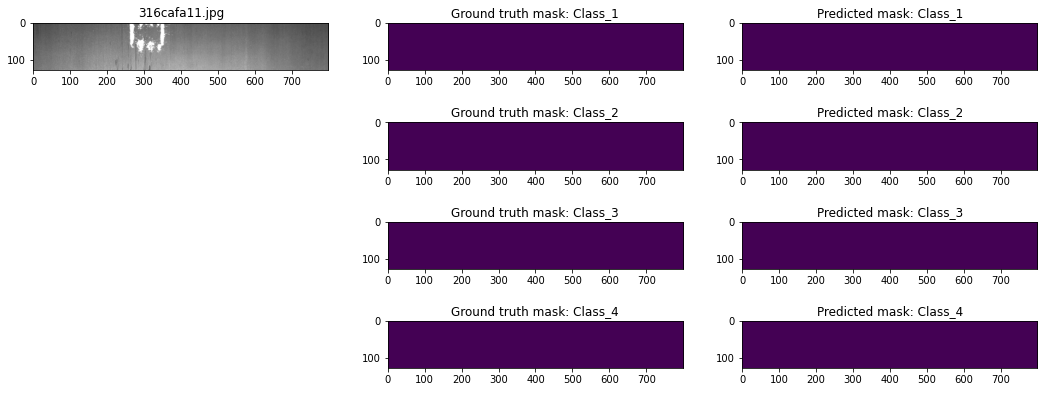

------------------------------------------------------------------------------------------------------------------------------------------------------


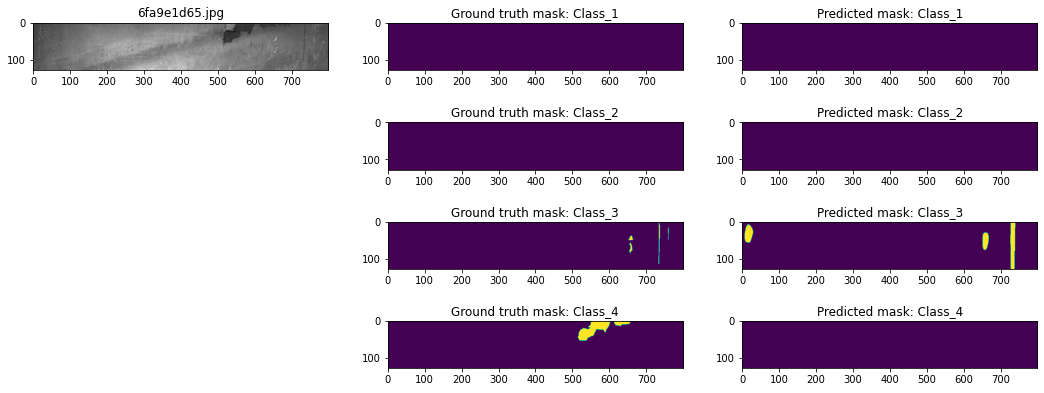

------------------------------------------------------------------------------------------------------------------------------------------------------


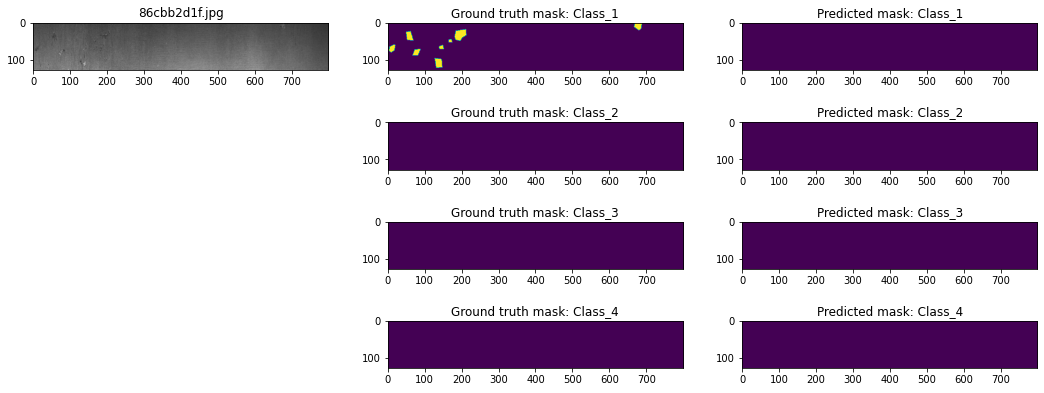

------------------------------------------------------------------------------------------------------------------------------------------------------


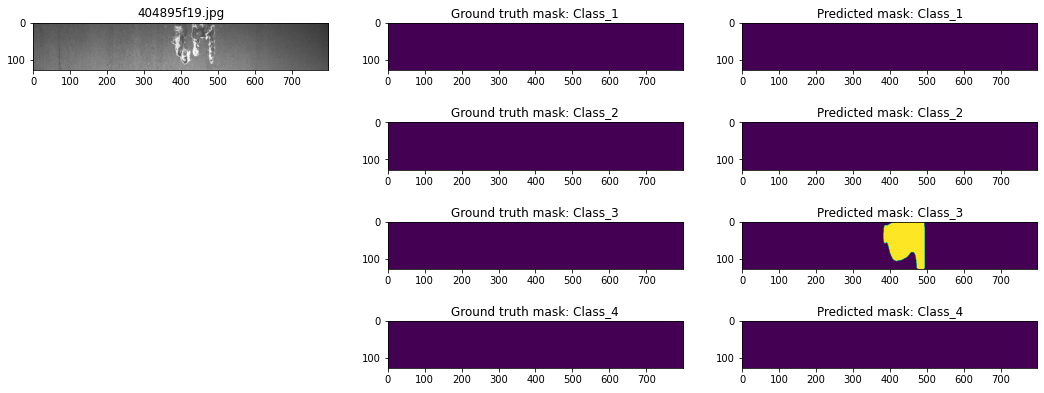

------------------------------------------------------------------------------------------------------------------------------------------------------


In [0]:
visualize_defects(train_data,model_best)

### Validation set

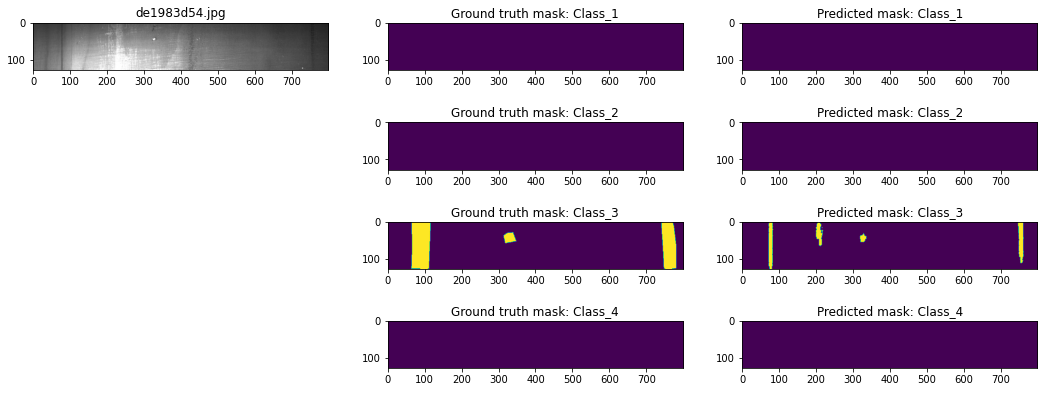

------------------------------------------------------------------------------------------------------------------------------------------------------


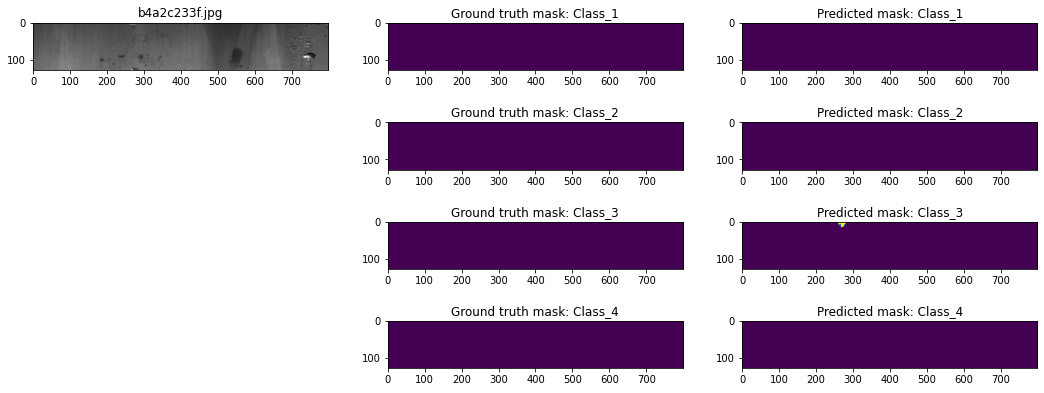

------------------------------------------------------------------------------------------------------------------------------------------------------


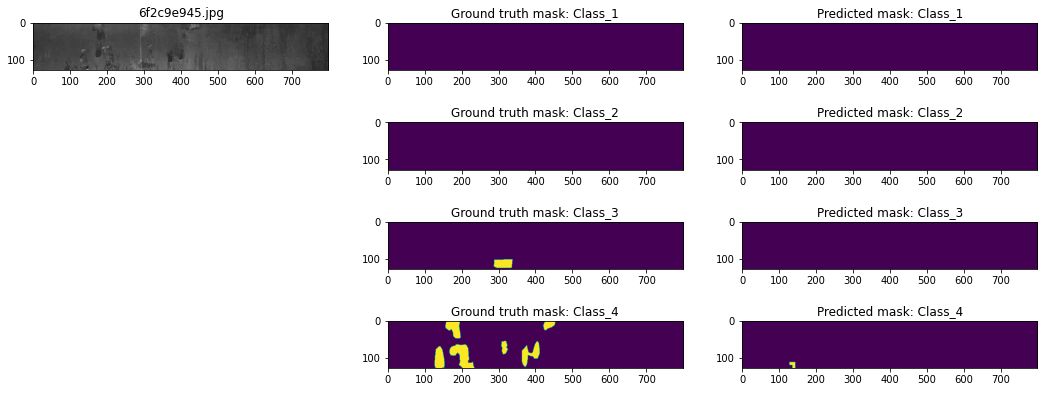

------------------------------------------------------------------------------------------------------------------------------------------------------


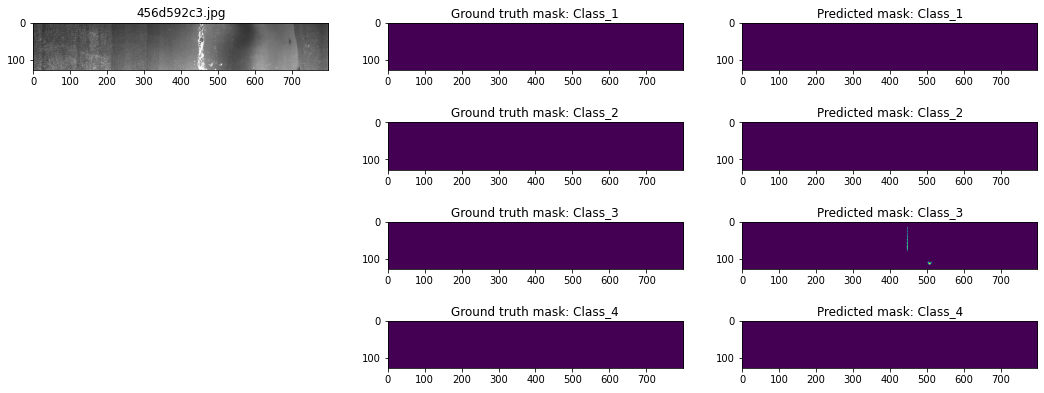

------------------------------------------------------------------------------------------------------------------------------------------------------


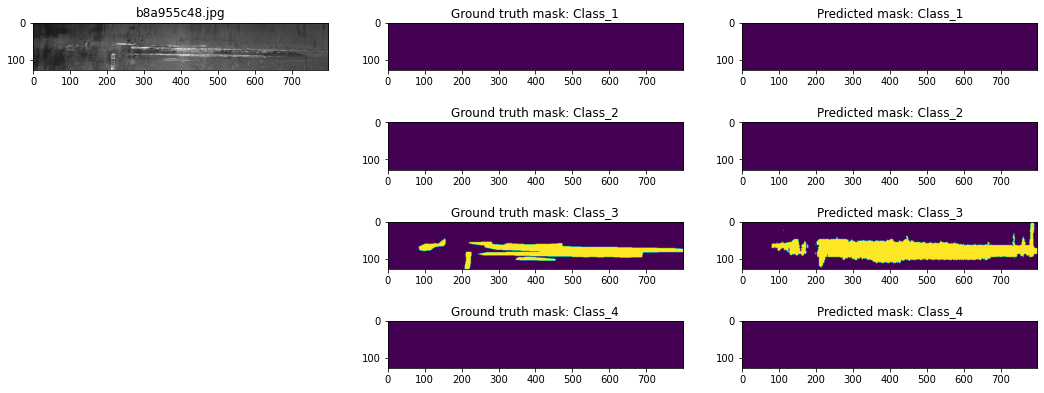

------------------------------------------------------------------------------------------------------------------------------------------------------


In [0]:
visualize_defects(cv_data,model_best)

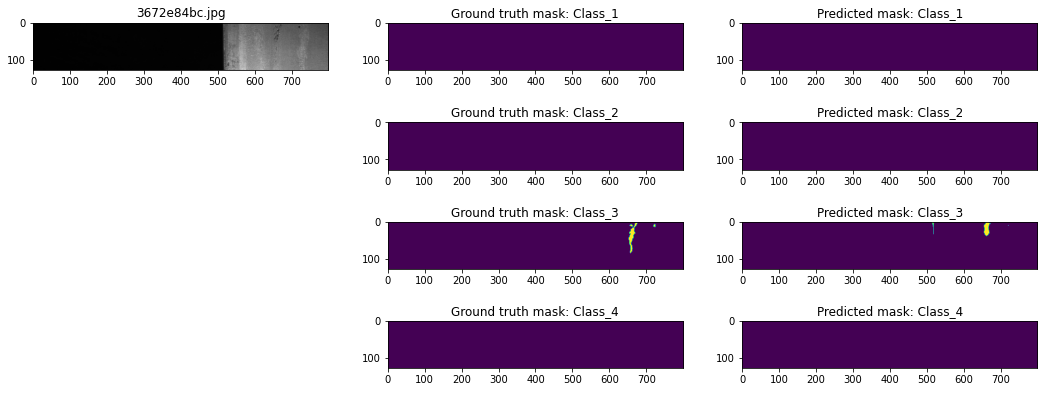

----------------------------------------------------------------------------------------------------


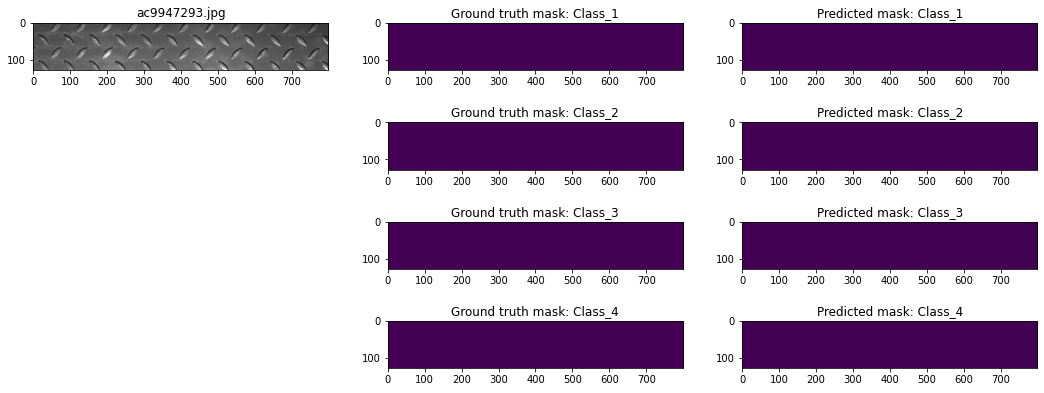

----------------------------------------------------------------------------------------------------


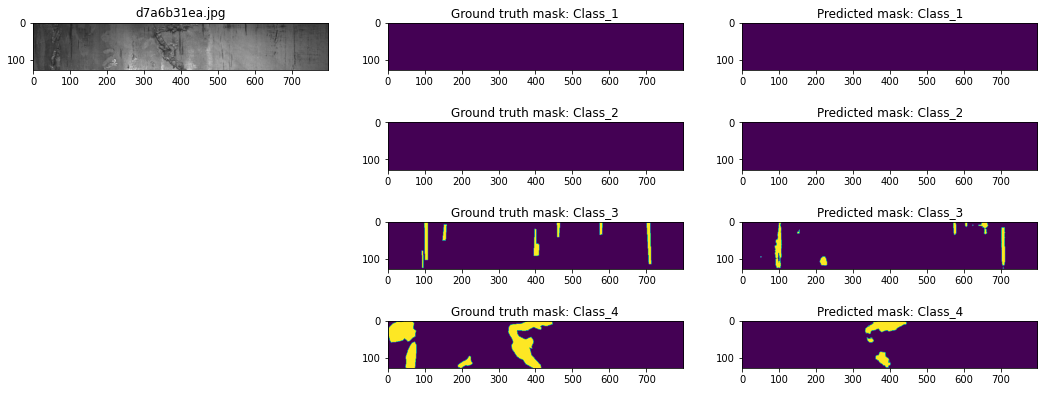

----------------------------------------------------------------------------------------------------


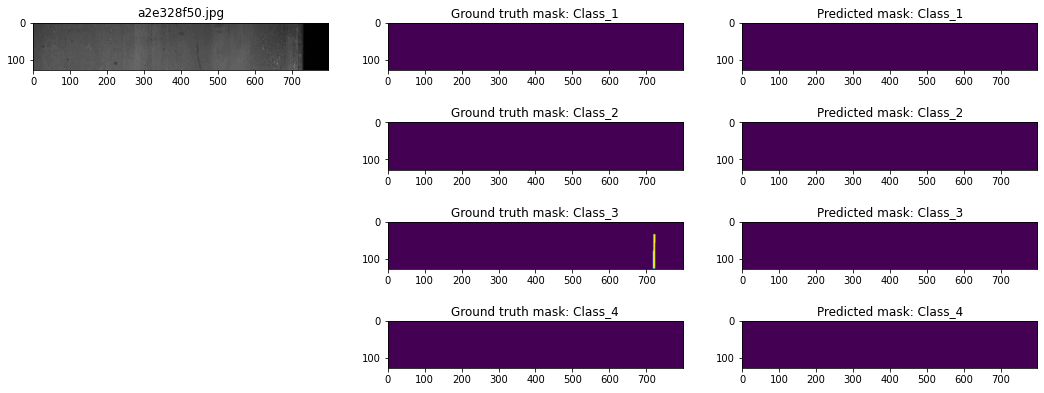

----------------------------------------------------------------------------------------------------


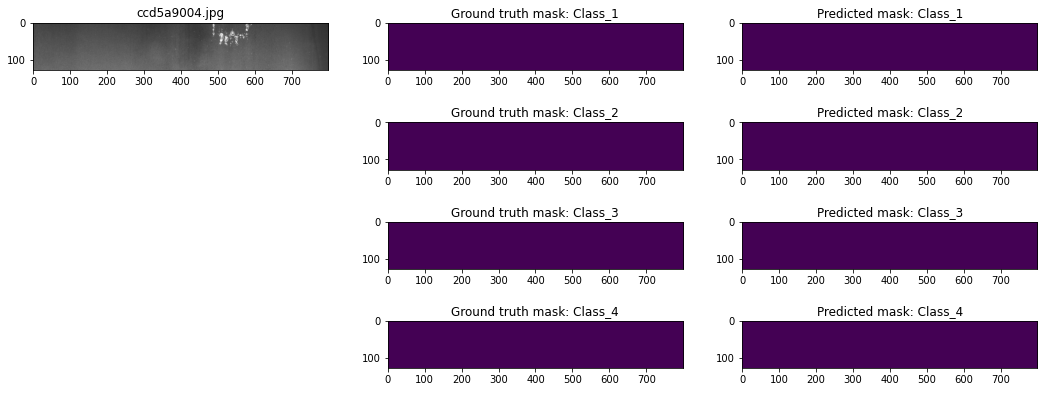

----------------------------------------------------------------------------------------------------


In [0]:
visualize_defects(cv_data,model_best)

## 3.6 Predicting defects on raw test images

### Redefining the FCN8 architecture for original image size of 256x1600

In [0]:
#https://keras.io/models/model/#fit_generator
model= fcn_8(img_shape= (256,1600,3), base= 4, dropout= 0.3, n_classes= 4)
model.compile(optimizer=Adam(), loss=bce_dice_loss, metrics=[dice_coef])
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 256, 1600, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 256, 1600, 16 448         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_61 (BatchNo (None, 256, 1600, 16 64          block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 256, 1600, 16 2320        batch_normalization_61[0][0]     
____________________________________________________________________________________________

In [0]:
model.set_weights(model_best.get_weights())

### Predicting on full 256x1600 raw test images

In [0]:
# Predicting on test images
from tqdm import tqdm
import cv2
data_path = '/content/' + 'test_images/'
files = list(os.listdir(data_path))
rle_lst = [] #list to store defect in run length encoding format
img_classId= [] #list to store Image ID + classId

for f in tqdm(files):
    X = np.empty((1,256,1600,3),dtype=np.float32)
    img = cv2.imread(data_path + f)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    X[0,] = img
    mask = model.predict(X)
    rle_m = np.empty((256,1600),dtype=np.uint8)
    for i in range(4):
        rle_m = mask[0,:,:,i].round().astype(int)
        rle = mask2rle(rle_m)
        rle_lst.append(rle)
        img_classId.append(f+'_'+str(i+1))

100%|██████████| 5506/5506 [05:48<00:00, 15.82it/s]


In [0]:
output = {'ImageId_ClassId':img_classId, 'EncodedPixels' : rle_lst}
import pandas as pd
output_df = pd.DataFrame(output)
output_df.to_csv('submission_fcn8_256x1600.csv', index=False)

**With this submission, I got a private dice coefficient score of 0.82818 & a public score of 0.84935.**

## 3.7 Visualizing defects of raw test images(256x1600)

**Please refer to the "visualize_defects_test" function in Utility functions section.**

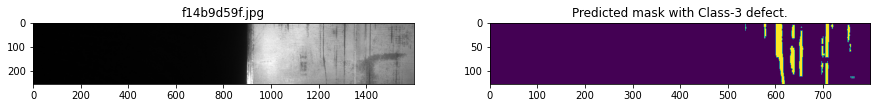

------------------------------------------------------------------------------------------------------------------------------------------------------


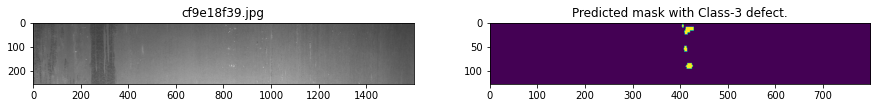

------------------------------------------------------------------------------------------------------------------------------------------------------


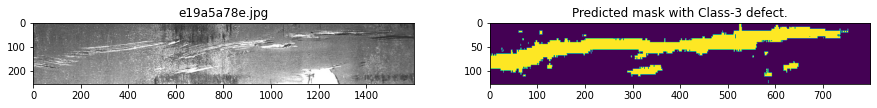

------------------------------------------------------------------------------------------------------------------------------------------------------


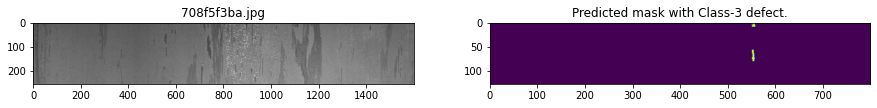

------------------------------------------------------------------------------------------------------------------------------------------------------


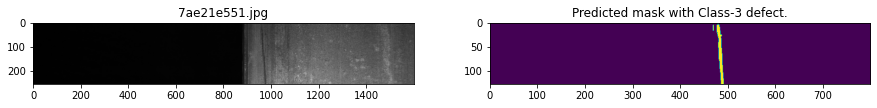

------------------------------------------------------------------------------------------------------------------------------------------------------


In [0]:
visualize_defects_test(output_df,5)

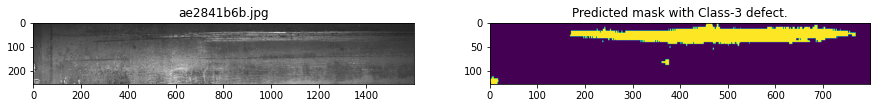

------------------------------------------------------------------------------------------------------------------------------------------------------


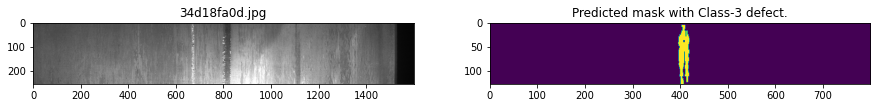

------------------------------------------------------------------------------------------------------------------------------------------------------


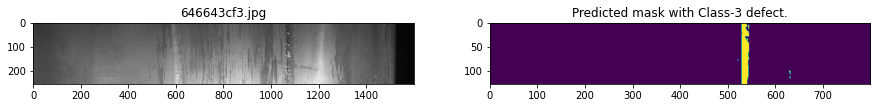

------------------------------------------------------------------------------------------------------------------------------------------------------


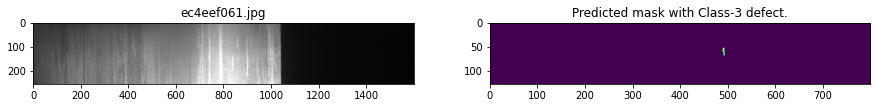

------------------------------------------------------------------------------------------------------------------------------------------------------


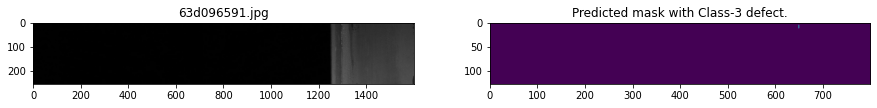

------------------------------------------------------------------------------------------------------------------------------------------------------


In [0]:
visualize_defects_test(output_df,5)

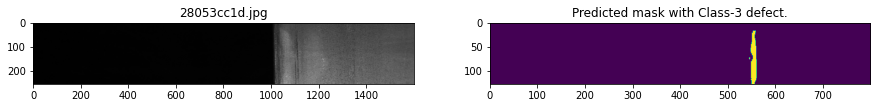

------------------------------------------------------------------------------------------------------------------------------------------------------


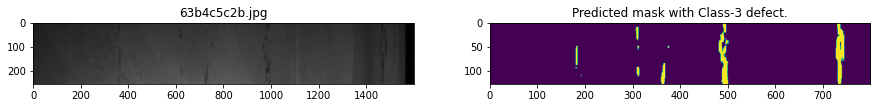

------------------------------------------------------------------------------------------------------------------------------------------------------


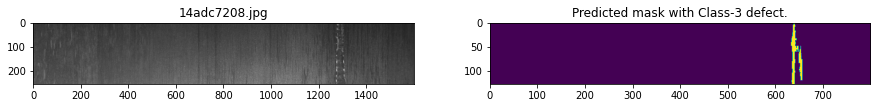

------------------------------------------------------------------------------------------------------------------------------------------------------


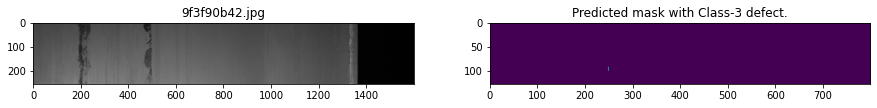

------------------------------------------------------------------------------------------------------------------------------------------------------


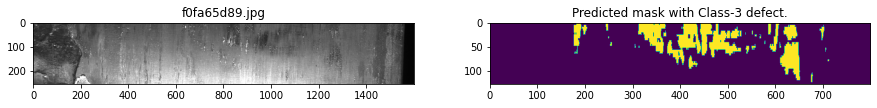

------------------------------------------------------------------------------------------------------------------------------------------------------


In [0]:
visualize_defects_test(output_df,5)

<h1 style="text-align:center;font-size:40px;" > Results Summary </h1>

In [2]:
#Ref: http://zetcode.com/python/prettytable/
from prettytable import PrettyTable


x = PrettyTable()
x.field_names = ["Architecture","Test Dice_coeff-Private","Test Dice_coeff-Public"]
x.add_row(["UNET",0.81171,0.80041])
x.add_row(["SEGNET",0.83437,0.84741])
x.add_row(["FCN-8",0.82818,0.84935])
print(x)

+--------------+-------------------------+------------------------+
| Architecture | Test Dice_coeff-Private | Test Dice_coeff-Public |
+--------------+-------------------------+------------------------+
|     UNET     |         0.81171         |        0.80041         |
|    SEGNET    |         0.83437         |        0.84741         |
|    FCN-8     |         0.82818         |        0.84935         |
+--------------+-------------------------+------------------------+


<h1 style="text-align:center;font-size:40px;" > Conclusion </h1>

- Countered the issue of class imbalance by assigning class weights (calculated using SKLearn) during the training stage
- Model training for all architectures was done on resized 128x800 images considering efficiency and computational power
- Model prediction on full sized raw test images (256x1600) gave better scores compared to prediction on half images (128x800)
- Highest score of 0.83437 on private leaderboard & 0.84935 on public leaderboard was obtained with SEGNET & FCN-8 architecture respectively. These scores were better compared to the basic U-NET architecture which was the first cut aproach.

<h1 style="text-align:center;font-size:40px;" > Steps followed to solve this case study(in brief): </h1>

1. The first basic step was to carry out EDA on the defect data. This included analysing images in train & test folder to get a gist of defective & non-defective images, knowing the basic properties of the given images, analysing response label, determining class weights, checking number of labels tagged to each image & observing images with defects belonging to each class.
2. EDA was then followed by Data preparation stage where a master csv file was prepared in which each row represented a image with all possible defects that image possessed.
3. The final data was split into train & CV data in the ratio 85:15 and basic utility functions were defined.
4. Next was the data generator phase where train & validation data was generated in order to feed the keras models with augmented images (in case of train) and ground truth masks.
5. Once the flow of input was set, it was time to implement various segmentation architectures, This included UNET, SEGNET & FCN-8.
6. For each architecture, the performance was checked on the validation image data and few predicted masks were observed.
7. Predictions were made on full sized (i.e 256x1600) raw test images and the predicted masks were observed.
8. Predictions on test images were uploaded on kaggle to get the dice coefficient score